In [1]:
import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
import dask.dataframe as dd
import matplotlib.cm as cm
import os

In [2]:
Analise_Potencia = True
Analise_Reserva = True
Analise_GenbySource = True
Analise_Tensão = True
Analise_Shunt = True
Analise_Linhas = True
Analise_Inter_HVDC = True
Analise_Correlação = True
Analise_Cluster = True

In [3]:
mainpath = 'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS'
dic_cenarios = {
                # 'MPA FNS Lim Scenario 2022' : f'{mainpath}/MPV_(FNS Lim)_RC/',
                # 'V1A1F2 Scenario 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev1_2026/',
                'V1A1F2 Scenario 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev2_2026/',
                # 'V1A1F3 Scenario 2026' :f'{mainpath}/V1A1F3_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F4 Scenario 2026' :f'{mainpath}/V1A1F4_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F5 Scenario 2026' :f'{mainpath}/V1A1F5_RESP_FNS_lim_rev1_2026/',
                # 'V2A2F2 2026' :f'{mainpath}/V2A2F2_REV02_2026/',
                # 'V2A2F3 2026' :f'{mainpath}/V2A2F3_REV02_2026/',
                # 'V2A2F4 2026' :f'{mainpath}/V2A2F4_REV02_2026/', 
                # 'V2A2F5 2026' :f'{mainpath}/V2A2F5_REV02_2026/',
                # 'V3A3F2 Scenario 2026 rev0' :f'{mainpath}/V3A3F2_REV0_2026/',
                # 'V3A3F3 Scenario 2026 rev0' :f'{mainpath}/V3A3F3_REV0_2026/',
                # 'V3A3F4 Scenario 2026 rev0' :f'{mainpath}/V3A3F4_REV0_2026/',
                # 'V3A3F5 Scenario 2026 rev0' :f'{mainpath}/V3A3F5_REV0_2026/',
                # 'V3A3F2 Scenario 2026 rev1' :f'{mainpath}/V3A3F2_REV1_2026/',
                # 'V3A3F3 Scenario 2026 rev1' :f'{mainpath}/V3A3F3_REV1_2026/',
                # 'V3A3F4 Scenario 2026 rev1' :f'{mainpath}/V3A3F4_REV1_2026/',
                # 'V3A3F5 Scenario 2026 rev1' :f'{mainpath}/V3A3F5_REV1_2026/',
                }

dirGeral = 'StaticAnalysis/Data/Geral/'
dirIndice = 'StaticAnalysis/Data/Indice_n_supremo/'
# dirIndice = 'StaticAnalysis/Data/Indice_n_2/'
dirRamos = 'StaticAnalysis/Data/Fluxo em Ramos/'
dirPotencia = 'StaticAnalysis/Data/Potencia/'

filenames = [
                (dirGeral + 'OPF_NC.csv', 'OPF_NC'), 
                (dirGeral + 'PWF_NC.csv', 'PWF_NC'),
                (dirGeral + 'Df_ger.csv', 'ger'), 
                (dirGeral + 'Df_nt.csv', 'nt'), 
                (dirRamos + 'Df_Linhas.csv', 'linhas'), 
                (dirRamos + 'Df_Trafo.csv', 'Trafo'), 
                (dirRamos + 'DF_Intercambios.csv', 'intercambios'), 
                (dirRamos + 'DF_HVDC.csv', 'HVDC'), 
                (dirIndice + 'Df_DPI_S2.csv', 'Index'), 
                (dirIndice +'Df_DPI_S4.csv', 'Index_PO'), 
                (dirIndice + 'Df_DPI_S3.csv', 'Index_Modif'), 
                (dirIndice +'Df_PQ_DPI_S1.csv', 'IndexDec_PQ'), 
                (dirIndice +'Df_PV_DPI_S1.csv', 'IndexDec_PV'), 
                (dirPotencia+'Df_MW-MVAR_PO.csv', 'pot_mw_mvar'),  
                (dirPotencia+'Df_Reserva_PO_MW.csv', 'pot_mw_reserv'), 
                (dirPotencia+'Df_Reserva_PO_MVAR.csv', 'pot_mvar_reserv'),
                (dirPotencia+'DF_POT_Reg.csv', 'ger_reg'),
            ]

intense_palette = sns.color_palette("bright", 12)  # You can adjust the number of colors as needed
namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}

In [4]:
import numpy as np
np.abs(-10)

10

# Data Processing

In [5]:
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

In [6]:
# Function to calculate indices for lines
def IndiceLinhas(df, n):

    df['MW_Flow'] = np.where(df['MW:From-To'] >= 0, df['MW:From-To'], df['MW:To-From'])
    df['PI_mva'] = (df['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt = df.groupby(
        ['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    # df_r_nt['PFI'] = df_r_nt['MW_Flow'] / df_r_nt['MVA']
    df_r_nt['Mva_index'] = df_r_nt['PI_mva'] ** (1 / (2 * n))

    return df_r_nt

# Function to flatten DataFrame
def flatdf(df, BG):
    df_reordered = df.reorder_levels(['key','Dia', 'Hora', 'Cenario', 'REG', BG])
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
    }
    df_reordered = df_reordered.rename(index=regionmap, level='REG')
    df_reordered_sorted = df_reordered.sort_index(level=['key','Dia', 'Hora', 'Cenario', 'REG'])
    df_reordered_sorted.rename(columns={'CSI_INF': 'DPI_inf', 'CSI_SUP': 'DPI_sup'}, inplace=True)

    lista = [[index[0], index[1], index[2], index[3]] for index in df_reordered.index]
    conjunto_filtros = set(map(tuple, lista))
    conjunto_filtros = tuple(sorted(conjunto_filtros))

    data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
    datapd = pd.DataFrame(data, index=conjunto_filtros)
    datapd.index.names = ['key','Dia', 'Hora', 'Cenario']
    
    columns = []
    for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
        for bg in df_reordered_sorted.loc[:, :, :, : ,reg, :].reset_index(BG)[BG].unique():
            for column in df_reordered_sorted.columns:
                reg_name = 'SE-CO' if reg == 'Sudeste-Centro-Oeste' else reg
                columns.append(f"{column}_{reg_name}_{bg}")

    datapd.columns = columns
    return datapd

# Function to read data
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

# Funtion to obtain the main features (buses) that contribute in the DPI_1 
def computefeatures(df_nt, df_ger, dfpq, dfpv):
    # Step 1: Merge DataFrames with only necessary columns
    dfpq_cols = ['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'CSI_INF', 'CSI_SUP']
    dfpv_cols = ['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type', 'CSI_INF', 'CSI_SUP']

    datafeatures_pq = df_nt.merge(dfpq[dfpq_cols], on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left')
    datafeatures_pq = datafeatures_pq[['BUS_ID', 'BUS_NAME', 'ARE', 'VBASEKV', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'B0_MVAR']]

    datafeatures_pv = df_ger.merge(dfpv[dfpv_cols], on=['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type'], how='left')
    datafeatures_pv = datafeatures_pv[['BUS_ID', 'BUS_NAME', 'ARE', 'Gen_Type', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'PG_MW', 'QG_MVAR']]

    # Step 2: Calculate Importance using vectorized operations
    datafeatures_pq['Importance_inf'] = datafeatures_pq['IndiceInf'] / datafeatures_pq['CSI_INF'].replace(0, np.nan)
    datafeatures_pq['Importance_sup'] = datafeatures_pq['IndiceSup'] / datafeatures_pq['CSI_SUP'].replace(0, np.nan)

    datafeatures_pv['Importance_inf'] = datafeatures_pv['IndiceInf'] / datafeatures_pv['CSI_INF'].replace(0, np.nan)
    datafeatures_pv['Importance_sup'] = datafeatures_pv['IndiceSup'] / datafeatures_pv['CSI_SUP'].replace(0, np.nan)

    # Step 3: Filter rows directly without fillna
    datafeatures_pq = datafeatures_pq[datafeatures_pq['B0_MVAR'].notna() & (datafeatures_pq['B0_MVAR'] != 0)]
    datafeatures_pv = datafeatures_pv[datafeatures_pv['QG_MVAR'].notna() & (datafeatures_pv['QG_MVAR'] != 0)]

    # Optional: Fill NaN values in other columns with zero if necessary
    datafeatures_pq.fillna(0, inplace=True)
    datafeatures_pv.fillna(0, inplace=True)
    
    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'BUS_NAME': 'first'
    }).reset_index()
    
    dfeatures_pv = datafeatures_pv.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'Gen_Type': 'first',
        'BUS_NAME': 'first'
    }).reset_index()
    
    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nbuses = 5
    
    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
    
    result_inf_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'Importance_inf', nbuses)[['REG', 'VBASEKV', 'BUS_ID', 'BUS_NAME', 'Importance_inf']]
    result_sup_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'Importance_sup', nbuses)[['REG', 'VBASEKV', 'BUS_ID', 'BUS_NAME', 'Importance_sup']]
    result_inf_pv = top_n_group(dfeatures_pv, ['REG', 'Gen_Type'], 'Importance_inf', nbuses)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_inf']]
    result_sup_pv = top_n_group(dfeatures_pv, ['REG', 'Gen_Type'], 'Importance_sup', nbuses)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_sup']]
    
    # Step 6: Filter by BUS_ID
    features_inf_pq = result_inf_pq[result_inf_pq['Importance_inf'] != 0]
    features_sup_pq = result_sup_pq[result_sup_pq['Importance_sup'] != 0]
    features_inf_pv = result_inf_pv[result_inf_pv['Importance_inf'] != 0]
    features_sup_pv = result_sup_pv[result_sup_pv['Importance_sup'] != 0]
    
    # Step 7: Pivot tables
    def pivot_table(df, values_list, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column='BUS_NAME'):
        filtered_df = df[df['BUS_ID'].isin(values_list)]
        pivot_df = filtered_df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df
    
    features_sup_pq_df = pivot_table(df_nt, features_sup_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_inf_pq_df = pivot_table(df_nt, features_inf_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_sup_pv_df = pivot_table(df_ger, features_sup_pv['BUS_ID'].to_list(), 'QG_MVAR')
    features_inf_pv_df = pivot_table(df_ger, features_inf_pv['BUS_ID'].to_list(), 'QG_MVAR')
    
    return features_sup_pq_df, features_inf_pq_df, features_sup_pv_df, features_inf_pv_df

# Funtion to obtain the main features (buses) that contribute in the DPI_1 
def computefeatures_2(df_nt, df_r_nt):

    datafeatures_pq = df_nt.merge(df_r_nt, on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left')[['From#', 'To#', 'From Name', 'To Name', '% L1', 'Mvar:Losses', 'Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'Mva_index']]

    # Step 2: Calculate Importance using vectorized operations
    datafeatures_pq['importance_lines'] = datafeatures_pq['% L1'] / datafeatures_pq['Mva_index'].replace(0, np.nan)
    datafeatures_pq.fillna(0, inplace=True)

    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby(['From#', 'To#']).agg({
        'importance_lines': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'From Name': 'first',
        'To Name':'first'
    }).reset_index()
    
    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nlines = 5
    
    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
    
    result_inf_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'importance_lines', nlines)[['REG', 'VBASEKV','From#', 'To#', 'From Name', 'To Name','importance_lines']]
    result_inf_pq = result_inf_pq.set_index(['From Name', 'To Name'])
    mask = df_nt[['From Name', 'To Name']].apply(tuple, axis=1)
    filteredlines = df_nt[mask.isin(result_inf_pq.index)]

    # Step 7: Pivot tables
    def pivot_table(df, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column=['From Name', 'To Name']):
        pivot_df = df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df

    features_inf_pq_df = pivot_table(filteredlines, ['% L1', 'Mvar:Losses'])
    # features_inf_pq_df = pivot_table(filteredlines, ['MW_Flow'])
    features_inf_pq_df.columns = [' |'.join(filter(None, col)).strip() for col in features_inf_pq_df.columns]

    return  features_inf_pq_df

# Function to filter data based on non-convergent conditions
def filtarNC(df_list):
    df_filtrado = []
    for df_ in df_list:
        cenario = df_['Cenario'][0]
        bool_PWF_NConv = df_indice_grop[
            df_indice_grop['Cenario'] == cenario
        ][['Dia', 'Hora']].apply(tuple, axis=1)
        filtro = df_[['Dia', 'Hora']].apply(tuple, axis=1).isin(bool_PWF_NConv)
        df_filtrado.append(df_[filtro])
    return df_filtrado

# Function to concatenate and process data (part 1)
def concatenation_1():
    data = {}
    
    print('====== Selecting Critical Buses as features ======')
    ddffpv = pd.concat(dfs['IndexDec_PV'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type', 'key'])
    ddffpq = pd.concat(dfs['IndexDec_PQ'], axis=0).set_index(['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'key'])
    Df_ger = pd.concat(dfs['ger'], axis=0)
    Df_nt = pd.concat(dfs['nt'], axis=0)
    data['features_sup_pq_df'], data['features_inf_pq_df'], data['features_sup_pv_df'], data['features_inf_pv_df'] = computefeatures(Df_nt, Df_ger, ddffpq.reset_index(), ddffpv.reset_index())
    
    print('====== Selecting Critical Lines as features ======')
    data['df_linhas'] = pd.concat(dfs['linhas'], axis=0)
    data['df_linhas'] = data['df_linhas'][(data['df_linhas']['L1(MVA)']!=9999) & (data['df_linhas']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))]
    dfl_r_nt = IndiceLinhas(data['df_linhas'], 2)
    data['features_lines'] = computefeatures_2(data['df_linhas'], dfl_r_nt.reset_index())

    print('====== Concatenation of Other Data ======')
    data['df_DPI'] = pd.concat([flatdf(ddffpq, 'VBASEKV'), flatdf(ddffpv, 'Gen_Type')], axis=1)
    data['df_ger_reg_concat'] = pd.concat(filtarNC(dfs['ger_reg']), axis=0)
    data['df_indice_group'] = pd.concat(dfs['Index_Modif'], axis=0).rename(columns={'Unnamed: 0': 'Indice'})
    df_intercambios_01 = pd.concat(dfs['intercambios'], axis=0).rename(columns={'Intercambio AC': 'Intercambio'})
    df_hvdc_01 = pd.concat(dfs['HVDC'], axis=0).rename(columns={'Nome Elo':'Intercambio', ' P(MW)': 'MW:From-To', ' Q(Mvar)': 'Mvar:From-To'})
    df_Indice_REG = pd.concat(dfs['Index'], axis=0).rename(columns={'level_0': 'Indice'})
    data['df_Trafo'] = pd.concat(dfs['Trafo'], axis=0).rename(columns={'% L1': '% L1_Trafo', 'Mvar:Losses': 'Mvar:Losses_Trafo'})
    data['df_reserva'] = pd.concat(dfs['pot_mw_reserv'], axis=0).set_index(['Dia', 'Hora', 'Cenario'])

    df_intercambios_01 = df_intercambios_01.set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])
    df_hvdc_01 = df_hvdc_01.set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])
    data['df_indice_grop'] = df_indice_grop.set_index(['key','Dia', 'Hora', 'Cenario'])
    data['df_indice_group'] = data['df_indice_group'].set_index(['key','Dia', 'Hora', 'Cenario'])
    data['df_Indice_REG'] = df_Indice_REG.set_index(['Indice', 'key','Dia', 'Hora', 'REG', 'Cenario'])

    concatenated_HVDC = pd.concat([
        df_hvdc_01.loc[:,:, :, :, 'Elo_FOZ-IBIUNA']['MW:From-To'],
        df_hvdc_01.loc[:,:, :, :, 'Elo_PVEL-ARARQ']['MW:From-To'],
        df_hvdc_01.loc[:,:, :, :, 'Elo_XINGU-SE']['MW:From-To'],
        # df_hvdc_01.loc[:,:, :, :, 'Elo_CPVBTB-PVEL']['MW:From-To']
    ], axis=1, keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE'])

    concatenated_FluxoAC = pd.concat([
        df_intercambios_01.loc[:,:, :, :, 'EXP_NE']['MW:From-To'],
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-N']['MW:From-To'],
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-SE']['MW:From-To'], 
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_N-S']['MW:From-To'],
        df_intercambios_01.loc[:,:, :, :, 'Fluxo_SUL-SECO']['MW:From-To']

    ], axis=1, keys=['EXP_NE', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_N-S','Fluxo_SUL-SECO'])

    data['df_Inter_AC_DC'] = concatenated_HVDC.merge(concatenated_FluxoAC, on=['key','Dia', 'Hora', 'Cenario'], how='left')
    return data

# Function to concatenate and process data (part 2)
def concatenation_2(data):
    print('====== Start processing (PO) ======')
    Df_ger = pd.concat(dfs['ger'], axis=0)

    Jirau = [7051, 7061]
    S_Antonio = [7050, 7062, 7064]
    G_Uhe_230_ACRO = [6888, 6892, 6891]
    Tucurui = [6419, 6420, 6422, 6424, 6425]
    B_Monte = [6729]
    Itaipu_50 = [1100]
    Itaipu_60 = [1107]
    I_Solt = [501]
    AngraI = [10]
    AngraII = [11]
    TPires = [4492]
    S_Mesa = [36]
    XINGO = [5061]
    Furnas = [16]

    DF_complete_PO = data['df_ger_reg_concat'].drop(columns=['REG', 'PG_FERV']).groupby(by=['key','Dia', 'Hora', 'Cenario']).sum(numeric_only=True)
    DF_complete_PO = data['df_indice_group'].merge(DF_complete_PO, on=['key','Dia', 'Hora', 'Cenario'], how='left')
    DF_complete_PO['PG_FERV'] = (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL']) / DF_complete_PO['PL_MW']
    DF_complete_PO['DL_MW'] = DF_complete_PO['PL_MW'] - (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL'])

    Df_ger = Df_ger[Df_ger['BUS_ID'].isin(Jirau + S_Antonio + Tucurui + B_Monte + Itaipu_50 + Itaipu_60 + I_Solt + G_Uhe_230_ACRO)]
    DF_complete_PO[['Jirau_MW', 'Jirau_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Jirau)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['S_Antonio_MW', 'S_Antonio_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(S_Antonio)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Tucurui_MW', 'Tucurui_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Tucurui)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['B_Monte_MW', 'B_Monte_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(B_Monte)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Itaipu_50_MW', 'Itaipu_50_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_50)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Itaipu_60_MW', 'Itaipu_60_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_60)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['I_Solt_MW', 'I_Solt_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(I_Solt)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['G_ACRO_230_MW', 'G_ACRO_230_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(G_Uhe_230_ACRO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['AngraI_MW', 'AngraI_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(AngraI)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['AngraII_MW', 'AngraII_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(AngraII)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['TPires_MW', 'TPires_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(TPires)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['S_Mesa_MW', 'S_Mesa_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(S_Mesa)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()
    DF_complete_PO[['Furnas_MW', 'Furnas_MVAR']] = Df_ger[Df_ger['BUS_ID'].isin(Furnas)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR']].sum()

    return DF_complete_PO

# Function to concatenate and process data (part 3)
def concatenation_3(data):
    print('====== Start processing (REG) ======')
    DFF_POT_REG = data['df_ger_reg_concat'].set_index(['Dia', 'Hora', 'REG', 'Cenario']).drop(columns='PG_FERV')
    
    df_linhas_500up = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([500, 525, 765])]
    df_linhas_500down = data['df_linhas'][data['df_linhas']['VBASEKV'].isin([230, 345, 440])]
    df_linhas_500up_grouped = df_linhas_500up.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
    df_linhas_500down_grouped = df_linhas_500down.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})
    df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)

    df_Trafo_grouped_REG = data['df_Trafo'][data['df_Trafo']['VBASEKV'].isin([230, 345, 440, 500, 525, 765])].groupby(by=['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1_Trafo': 'mean', 'Mvar:Losses_Trafo': 'sum'})
    
    DF_complete_PO_REG = df_linhas_grouped_REG.merge(DFF_POT_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

    df_Indice_REG_PV = data['df_Indice_REG'].loc['DPI_PV']
    df_Indice_REG_PQ = data['df_Indice_REG'].loc['DPI_PQ']
    df_REG_Cenario_PV = df_Indice_REG_PV.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PV = df_REG_Cenario_PV.merge(df_Trafo_grouped_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    df_REG_Cenario_PQ = df_Indice_REG_PQ.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

    Df_data_completo_reg = df_REG_Cenario_PQ[['OV DPI', 'UV DPI']].merge(df_REG_Cenario_PV, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    Df_data_completo_reg.rename(columns={'OV DPI_x': 'OV DPI_PQ', 'UV DPI_x': 'UV DPI_PQ', 'OV DPI_y': 'OV DPI_PV', 'UV DPI_y': 'UV DPI_PV'}, inplace=True)
    Df_data_completo_reg.fillna({'Mvar:Losses_500up': 0, '% L1_500up': 0, 'Mvar:Losses_500down': 0, '% L1_500down': 0}, inplace=True)

    return Df_data_completo_reg

# Main code execution
if __name__ == '__main__':
    print('Reading data...')
    dfs = read_data()
    df_indice_grop = pd.concat(dfs['Index_PO'], axis=0)
    
    print('Concatenating data...')
    DATA = concatenation_1()
    
    DF_complete_PO = concatenation_2(DATA)
    Df_data_completo_reg = concatenation_3(DATA)
    
    # Renaming regions
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
                }
    
    Df_data_completo_reg = Df_data_completo_reg.rename(index=regionmap, level='REG')


Reading data...
Concatenating data...
====== Selecting Critical Buses as features ======


C:\Users\david\AppData\Local\Temp\ipykernel_25472\2058326295.py:114: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
C:\Users\david\AppData\Local\Temp\ipykernel_25472\2058326295.py:114: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(dro

====== Selecting Critical Lines as features ======


C:\Users\david\AppData\Local\Temp\ipykernel_25472\2058326295.py:162: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)


====== Concatenation of Other Data ======
====== Start processing (PO) ======
====== Start processing (REG) ======


# Analise Convergencia

In [7]:
print('NUMERO TOTAL DE CASOS ANALISADOS: ',DATA['df_DPI'].shape[0])
print('NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF: ',pd.concat(dfs['OPF_NC'],axis=0).shape[0])
print('NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF: ',pd.concat(dfs['PWF_NC'],axis=0).shape[0])

NUMERO TOTAL DE CASOS ANALISADOS:  1344
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1323
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  0


In [8]:
for chave in dic_cenarios.keys():
    print("Cenario ", chave)
    dt = pd.concat(dfs['OPF_NC'],axis=0)
    dt_ = pd.concat(dfs['PWF_NC'],axis=0)
    print('NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF: ',dt[dt['Cenario']==chave].shape[0])
    print('NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF: ',dt_[dt_['Cenario']==chave].shape[0])
    

Cenario  V1A1F2 Scenario 2026
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1323
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  0


In [9]:
from datetime import datetime, timedelta
# =======================================Dataframe Mask========================================================
fechas = [dia for dia in range(1, 29)]
semihoras_dia = [(datetime(2022, 10, dia, 0, 0) + timedelta(minutes=30*i)).strftime('%d-%H-%M') for dia in fechas for i in range(48)]
df = pd.DataFrame({'Dia_Hora': semihoras_dia})
# Dividir la columna Dia_Hora en dos partes y asignarlas a nuevas columnas
df[['Dia', 'Hora']] = df['Dia_Hora'].str.split('-', n=1, expand=True)
df['Dia_Hora'] = df['Dia_Hora'].str.replace('-',', ', n=1)
df['Dia'] = df['Dia'].astype(int)

df_copias = [df] * len(dic_cenarios)
df_mask = pd.concat(df_copias, ignore_index=True)
df_mask['Dia'] = df_mask['Dia'].astype(int)
scenarios_column = [scenario  for scenario in dic_cenarios.keys() for _ in range(1344) ]
df_mask['Cenario'] = scenarios_column

# Graficos de Potência

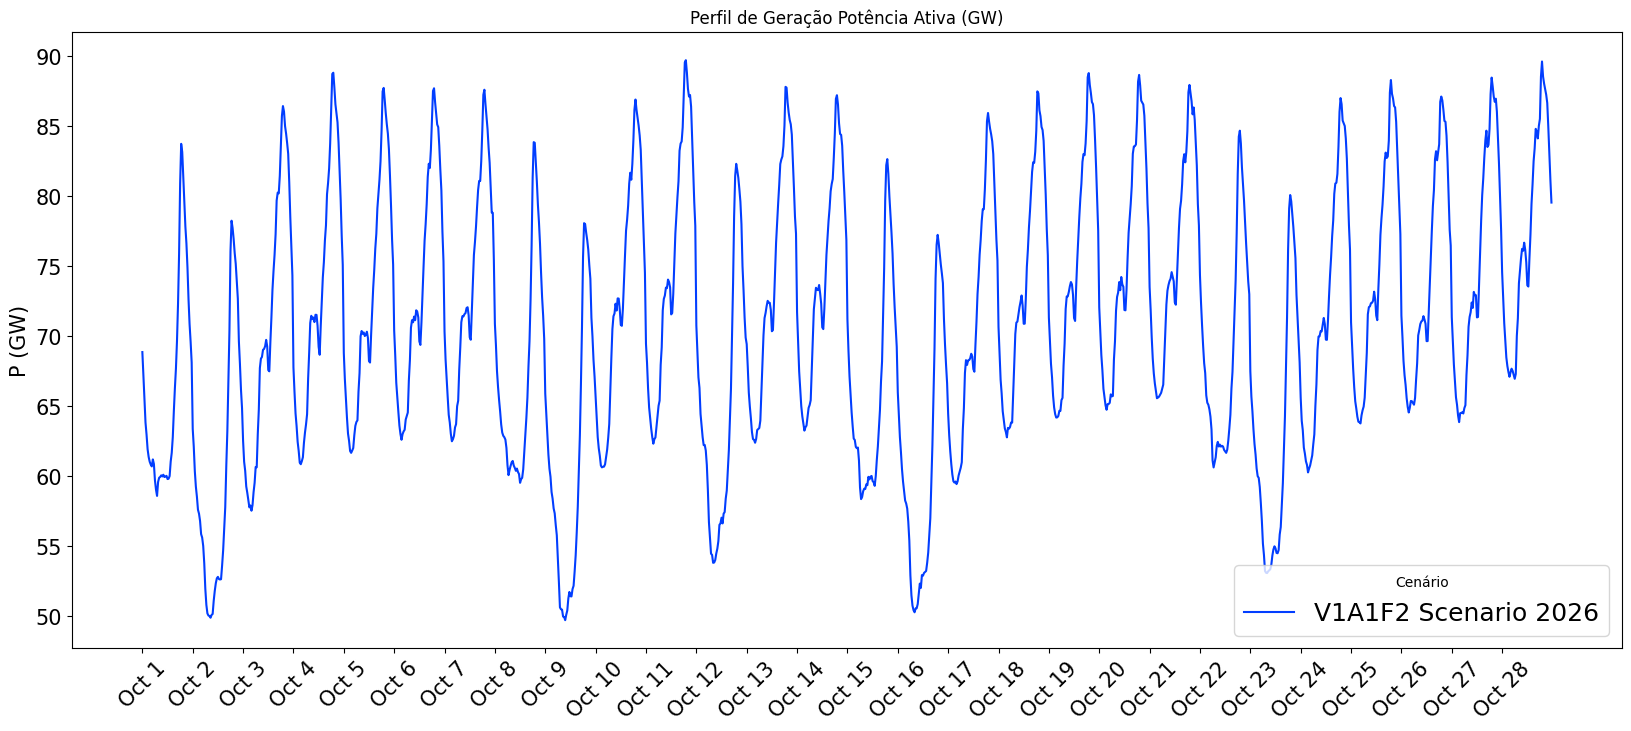

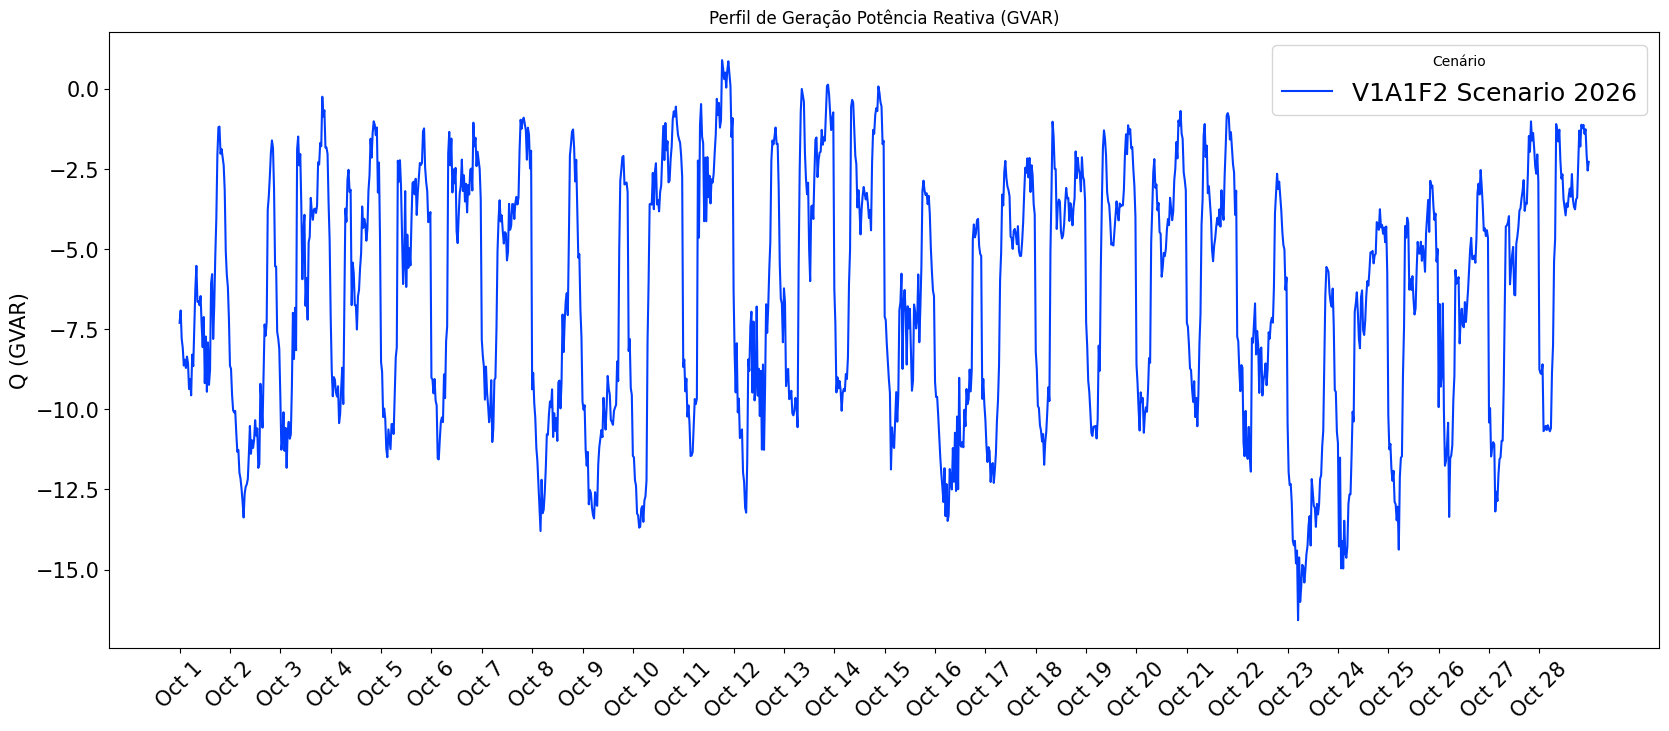

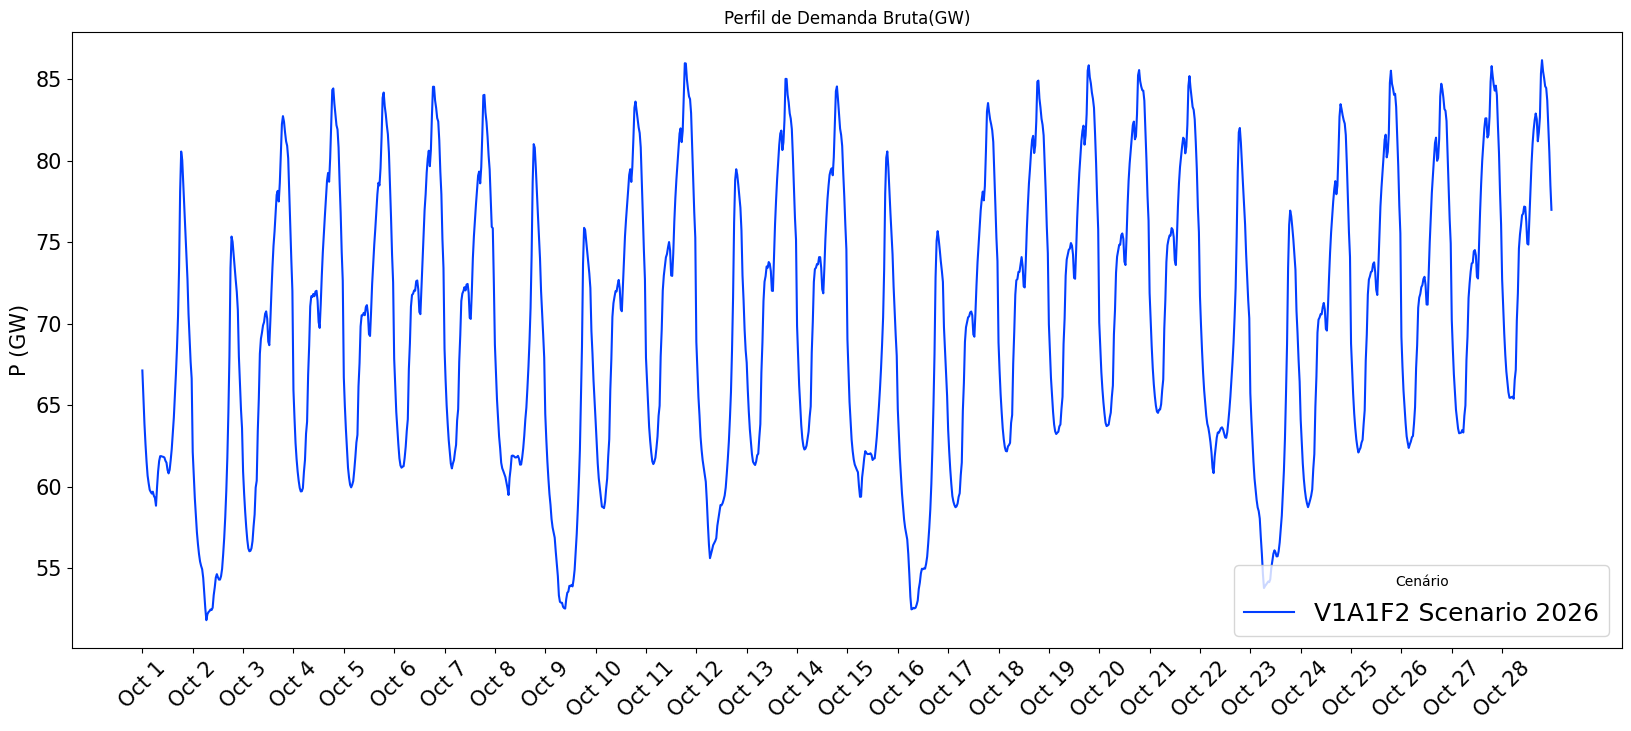

70.75341965773809


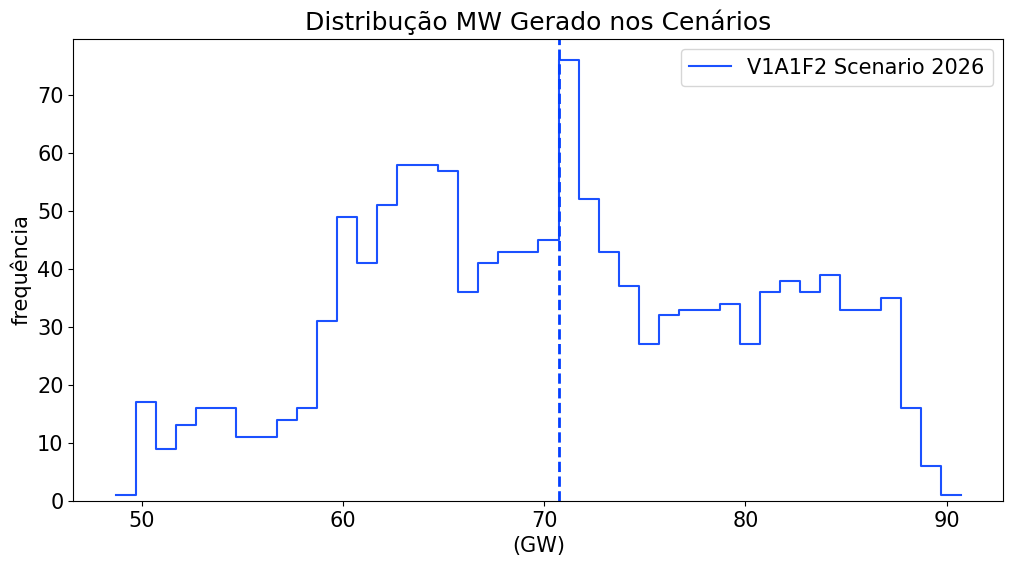

-6.471125723958333


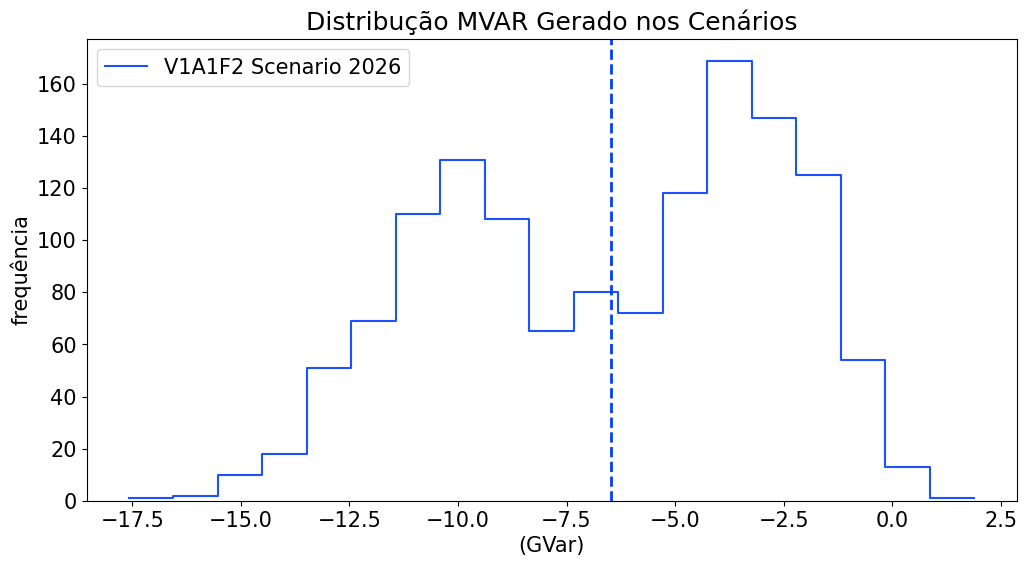

8.112621636904763


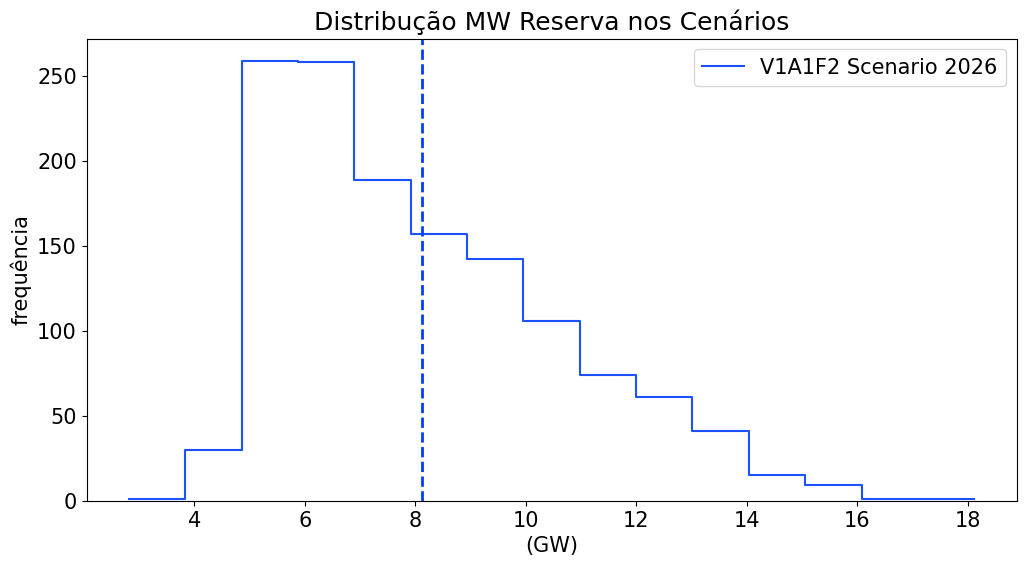

-16.86081138392857


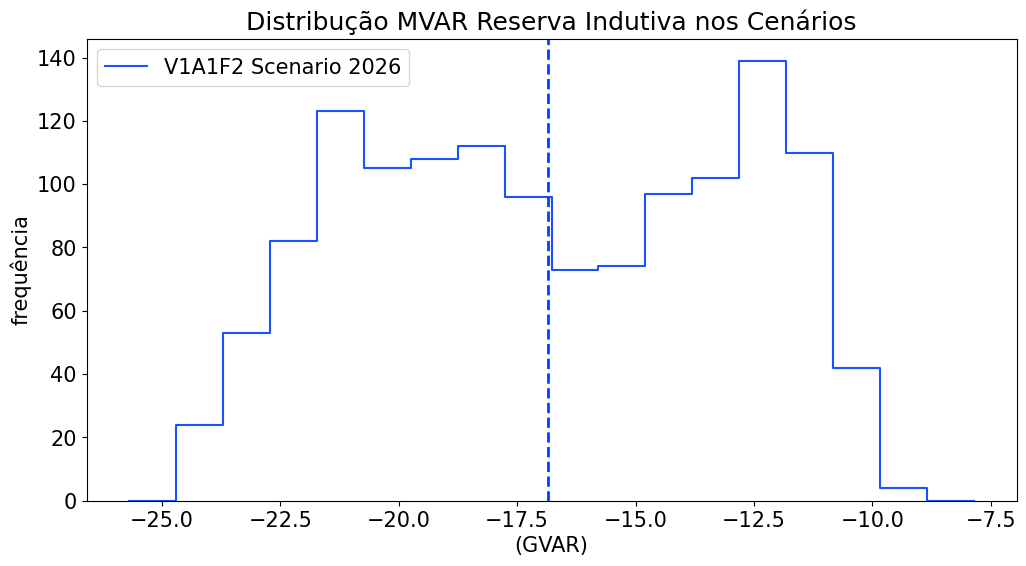

21.915131109375


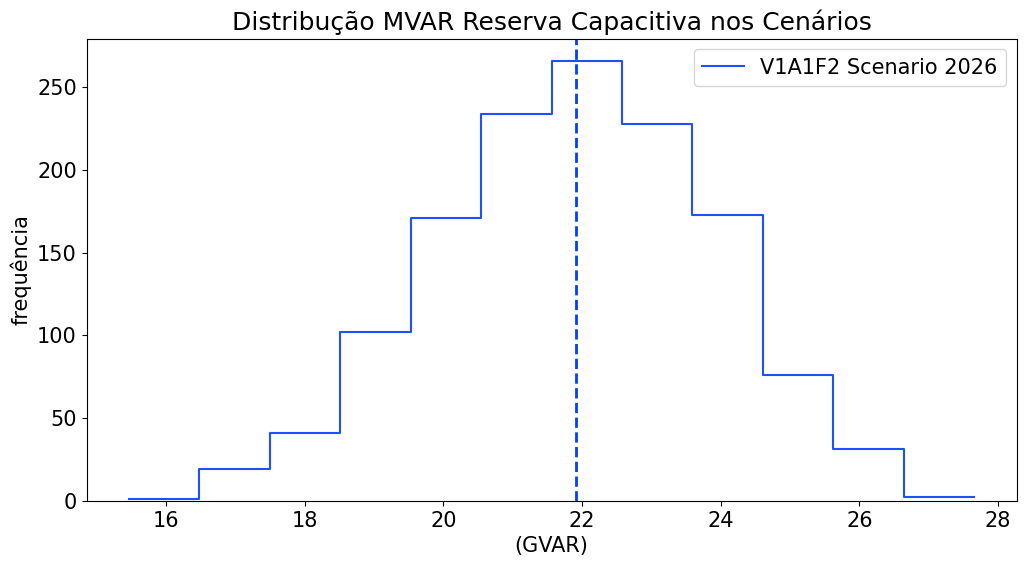

In [10]:
def plot_perfil_pot(df, columna, ylbl, titulo, ylim = None, day = False, variavel = None, otherplot = False):

    fig, ax = plt.subplots(figsize=(20, 8))
    for cenario in df['Cenario'].unique():
        dff = df[df['Cenario'] == cenario]
        dff_ = df_mask.merge(dff, on=['Dia','Hora', 'Cenario'], how='left')
        plt.plot(dff_['Dia_Hora'], dff_[columna]/1000, label=namescenarios[cenario][0], color=namescenarios[cenario][1], )

        
    plt.legend(title='Cenário', fontsize=18)
    plt.title(titulo)
    plt.xlabel('Operation Point',fontsize=15)
    plt.ylabel(ylbl, fontsize=15)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    ax.xaxis.set_major_locator(plt.MaxNLocator(12))
    if day:
        days = ['Oct {}'.format(i+1) for i in range(28)]
        plt.xticks(ticks=[i*48 for i in range(28)], labels=days, rotation=45)
        plt.xlabel('',fontsize=10)
    # plt.grid('-',lw = 0.4, alpha=0.50)
    if ylim != None:
        plt.ylim(ylim)
    if otherplot == False:
        plt.show()

def distribution_plot(df, columna, xlbl, titulo, variavel = None):

    plt.figure(figsize=(12, 6))
    for dff in df:
        if variavel == None:
            cenario = dff['Cenario'].iloc[0]
        else:
            cenario = dff[variavel].iloc[0]

        valuegw = dff[columna]/1000
        max= dff[columna].max()/1000
        min= dff[columna].min()/1000
        sns.histplot(valuegw, kde=False, label=namescenarios[cenario][0], color=namescenarios[cenario][1], bins=50, binwidth = 1, binrange =[min-1, max+1]  ,multiple="stack",alpha=0.90, element='step',fill=False, line_kws = {
        "linewidth": 2,  # Example: Make the line thicker
        "linestyle": "--" # Example: Use a dashed line
        })
        plt.axvline(valuegw.mean(), color=namescenarios[cenario][1], linestyle='dashed', linewidth=2)
        print(valuegw.mean())

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15)
    plt.ylabel('frequência', fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(loc='best', fontsize = 15)
    # plt.grid()
    plt.show()


if Analise_Potencia:
    df_pot_mw_mvar_filt = pd.concat(filtarNC(dfs['pot_mw_mvar']), axis=0)
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='PG_MW', ylbl='P (GW)', titulo='Perfil de Geração Potência Ativa (GW)', day=True)
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='QG_MVAR', ylbl='Q (GVAR)', titulo='Perfil de Geração Potência Reativa (GVAR)', day=True)
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='PL_MW', ylbl='P (GW)', titulo='Perfil de Demanda Bruta(GW)', day=True)
    
    df_pot_mw_mvar_filt = filtarNC(dfs['pot_mw_mvar'])
    distribution_plot(df_pot_mw_mvar_filt,'PG_MW', '(GW)', 'Distribução MW Gerado nos Cenários')
    distribution_plot(df_pot_mw_mvar_filt,'QG_MVAR', '(GVar)', 'Distribução MVAR Gerado nos Cenários')
    
    if Analise_Reserva:
        df_mw_reserv = filtarNC(dfs['pot_mw_reserv'])
        distribution_plot(df_mw_reserv,' Reserve', '(GW)', 'Distribução MW Reserva nos Cenários')
        df_pot_mvar_reserv = filtarNC(dfs['pot_mvar_reserv'])
        distribution_plot(df_pot_mvar_reserv,'ReservaIND', '(GVAR)', 'Distribução MVAR Reserva Indutiva nos Cenários')
        distribution_plot(df_pot_mvar_reserv,'ReservaCAP', '(GVAR)', 'Distribução MVAR Reserva Capacitiva nos Cenários')

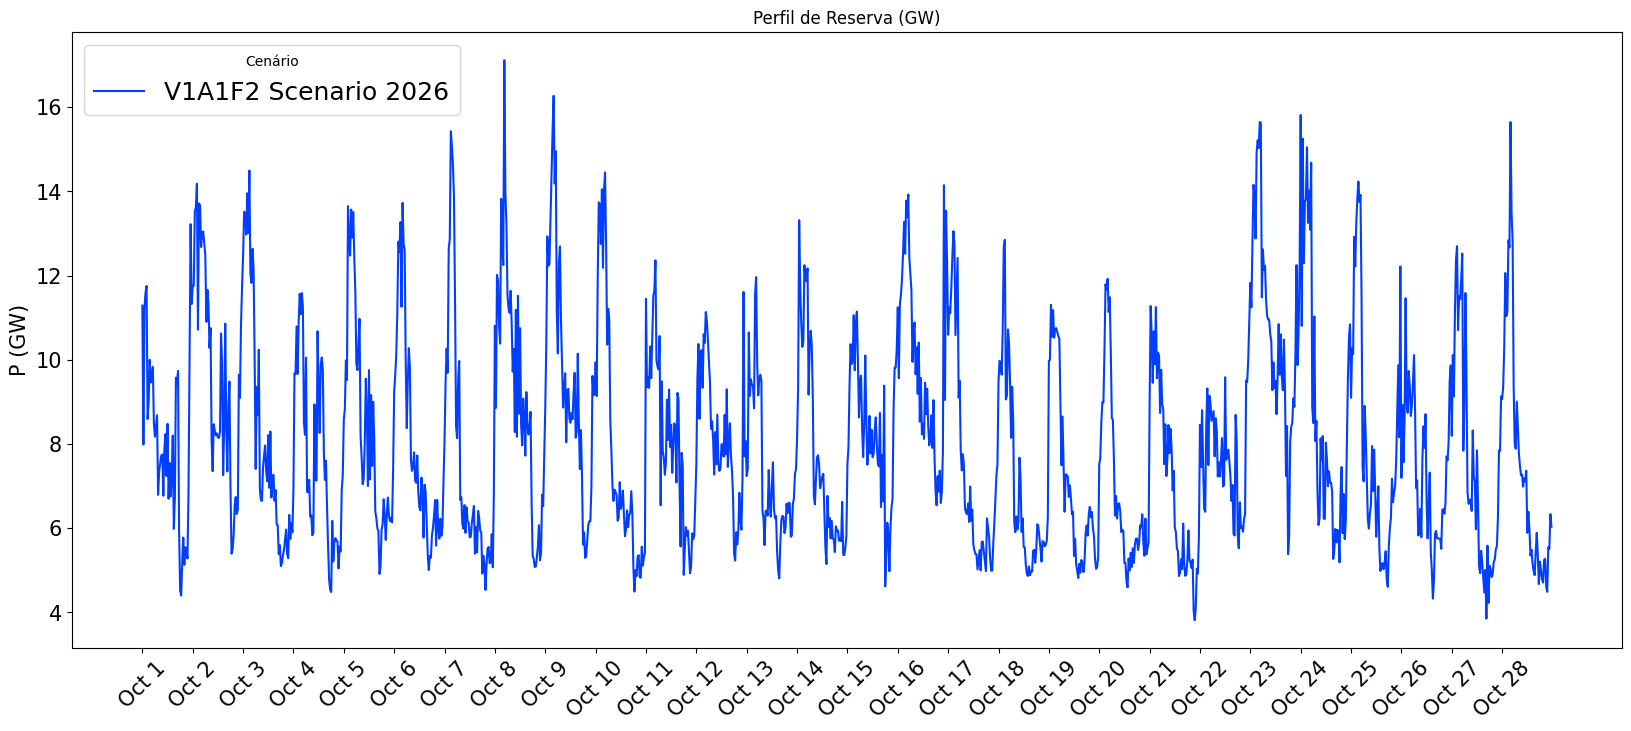

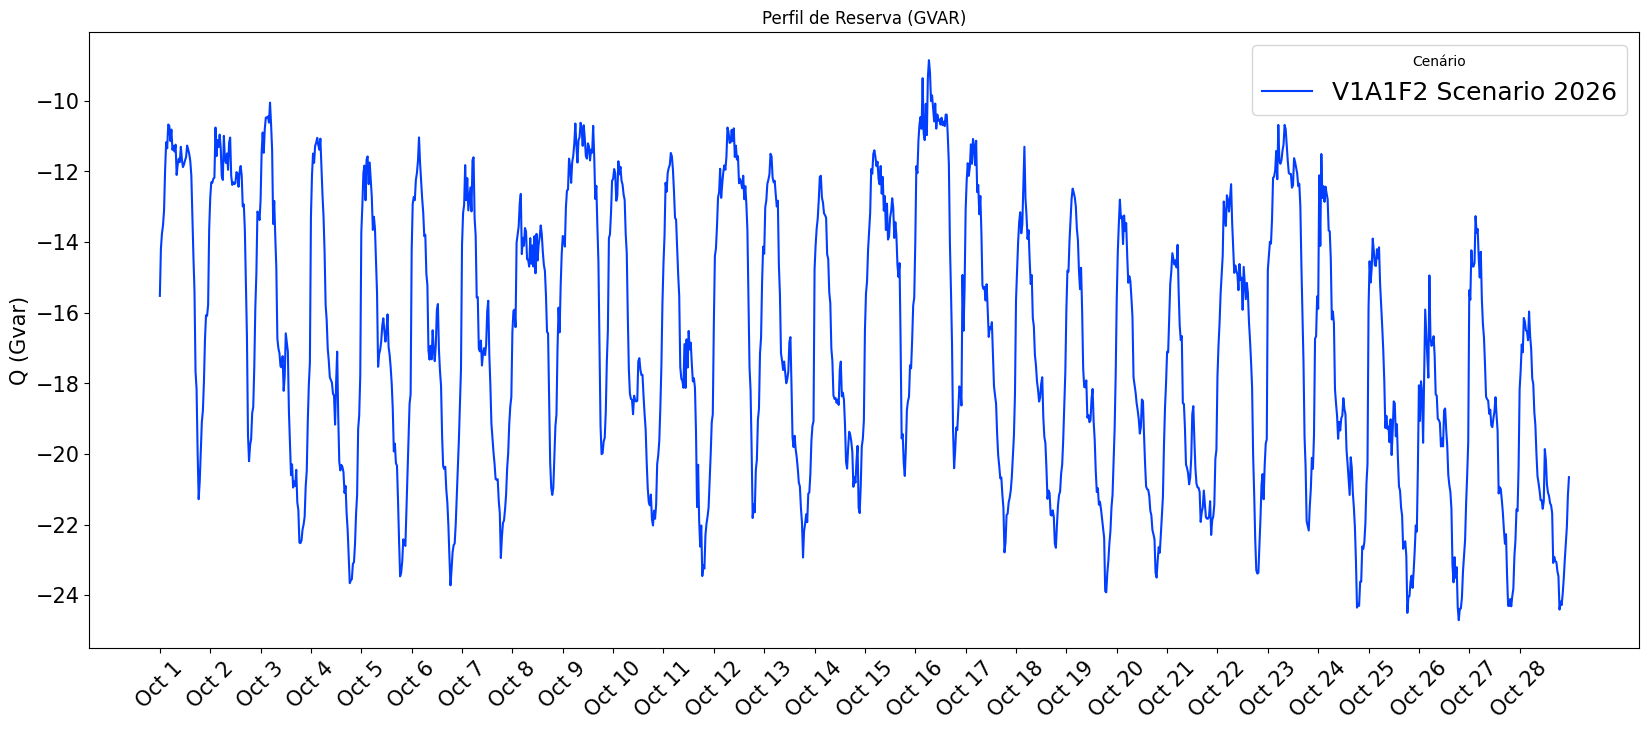

In [11]:
plot_perfil_pot(pd.concat(filtarNC(dfs['pot_mw_reserv']), axis=0), columna=' Reserve', ylbl='P (GW)', titulo='Perfil de Reserva (GW)', day=True)
plot_perfil_pot(pd.concat(filtarNC(dfs['pot_mvar_reserv']), axis=0), columna='ReservaIND', ylbl='Q (Gvar)', titulo='Perfil de Reserva (GVAR)', day=True)

In [12]:
pd.concat(filtarNC(dfs['pot_mw_reserv']), axis=0)[' Reserve'].mean()

8112.621636904762

In [13]:
df_pot_mw_mvar_filt[0]['QG_MVAR'].max()

892.3019999999997

55.48505919940476


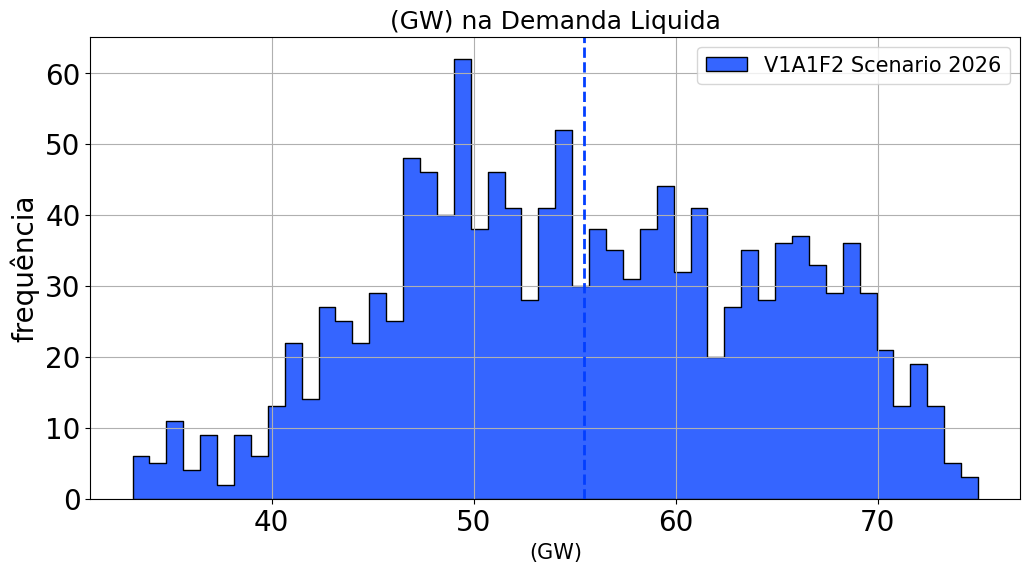

-6.471125723958334


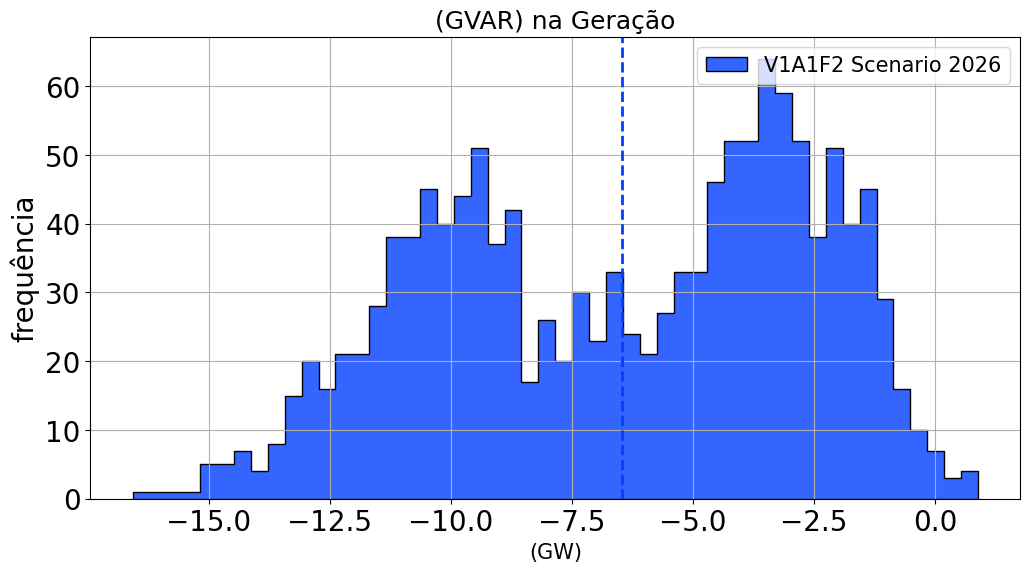

In [14]:
def distribution_plot(df, columna, xlbl, titulo, variavel = None):

    plt.figure(figsize=(12, 6))
    for cen in df['Cenario'].unique():
        dff = df[df['Cenario'] == cen]
        valuegw = dff[columna]/1000
        sns.histplot(valuegw, kde=False, label=namescenarios[cen][0], color=namescenarios[cen][1], bins=50, multiple="stack",alpha=0.80, element='step',fill=True, line_kws = {
        "linewidth": 2,  # Example: Make the line thicker
        "linestyle": "--" # Example: Use a dashed line
        })
        plt.axvline(valuegw.mean(), color=namescenarios[cen][1], linestyle='dashed', linewidth=2)
        print(valuegw.mean())

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15)
    plt.ylabel('frequência', fontsize=20)
    plt.tick_params(axis='both', labelsize=20)
    plt.legend(loc='best', fontsize = 15)
    plt.grid()
    plt.show()

distribution_plot(DF_complete_PO.reset_index(), 'DL_MW', '(GW)', '(GW) na Demanda Liquida')
distribution_plot(DF_complete_PO.reset_index(), 'QG_MVAR', '(GW)', '(GVAR) na Geração')

In [15]:
Analise_Potencia = True

7.0067113787202375


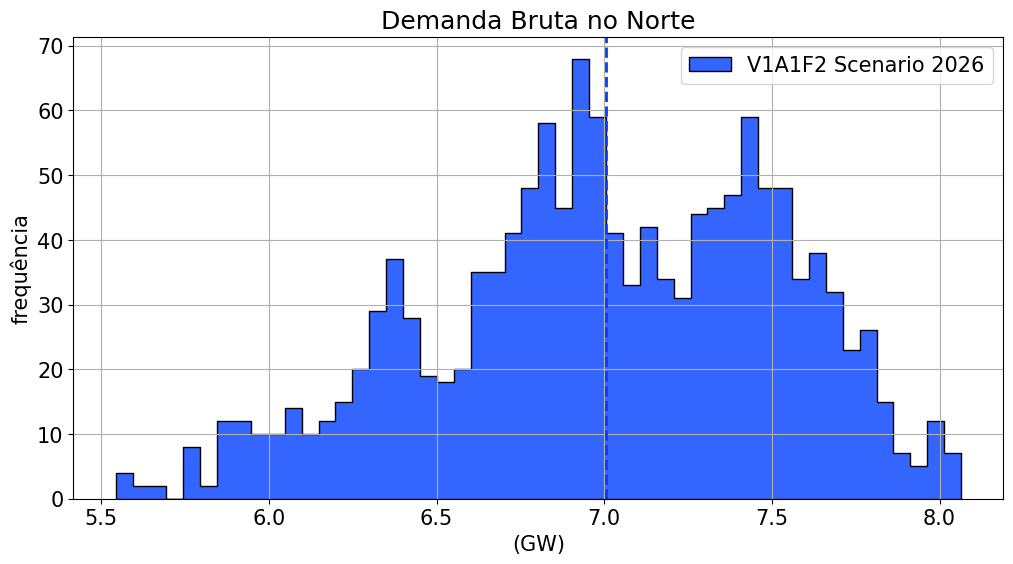

11.888422036458334


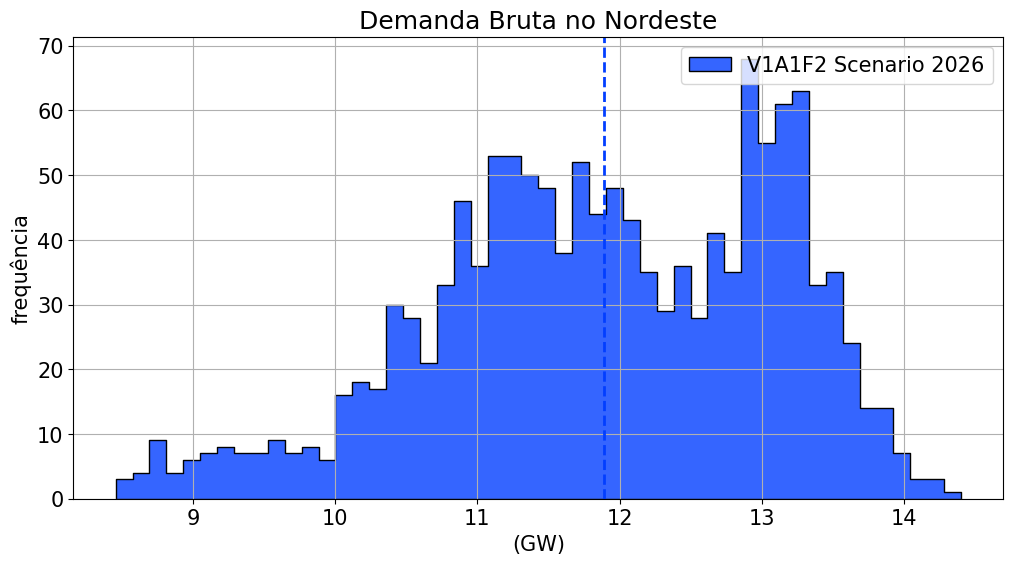

37.76341053943453


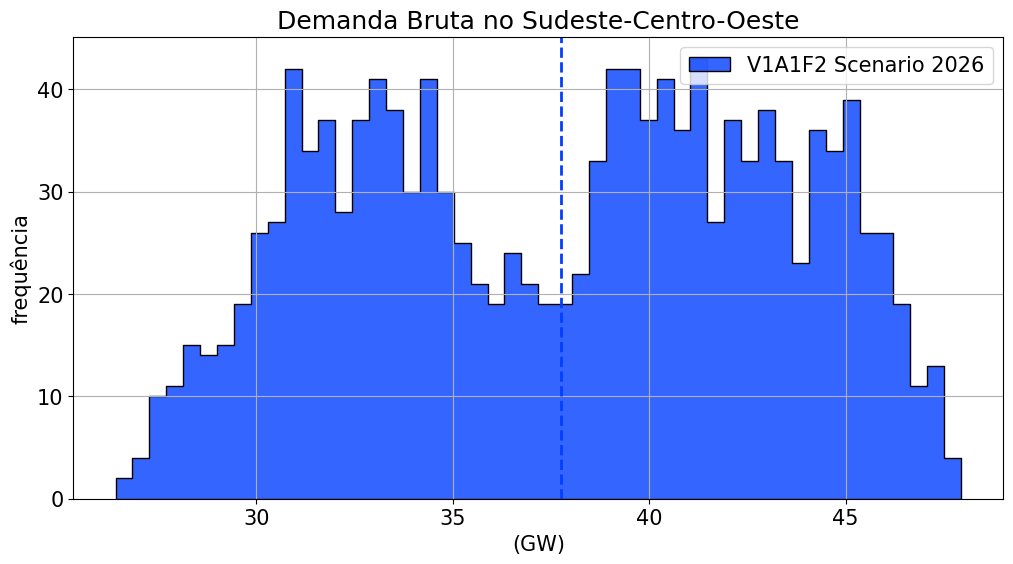

12.932738883184523


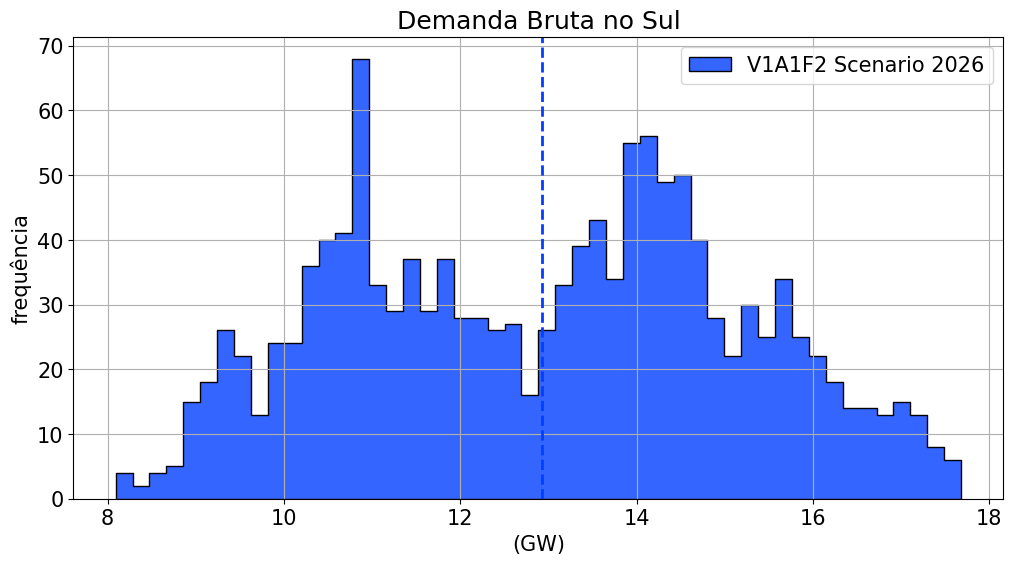

0.4031618831845239


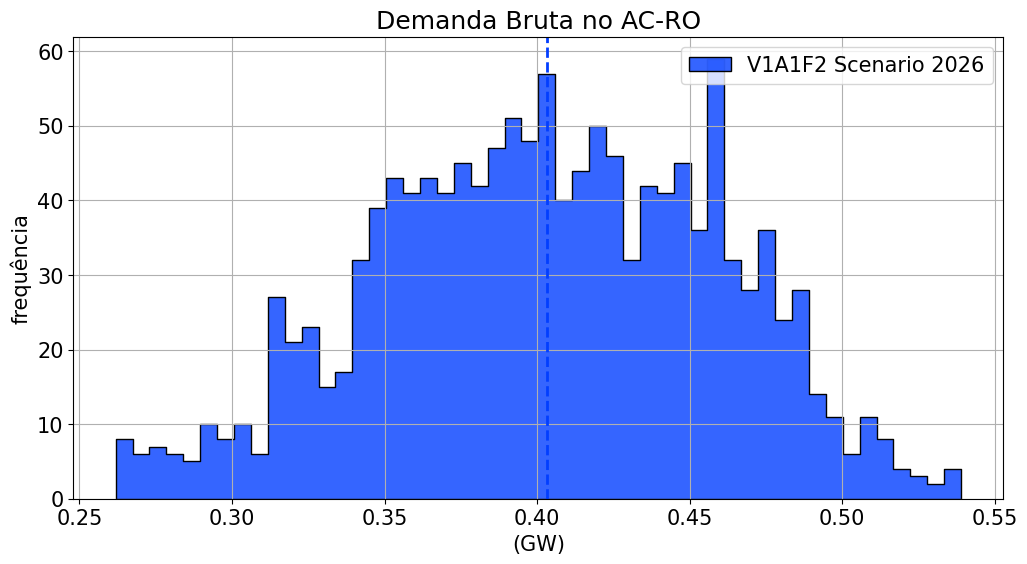

In [16]:
def distribution_plot_reg(df, columna, reg, xlbl, titulo):
    
    plt.figure(figsize=(12, 6))
    for df_ in df:
        dff = df_[df_['REG'] == reg]
        cenario = dff['Cenario'].iloc[0]
        valuegw = dff[columna]/1000
        sns.histplot(valuegw, kde=False, label=namescenarios[cenario][0], color=namescenarios[cenario][1], bins=50, multiple="stack",alpha=0.80, element='step',fill=True, line_kws = {
        "linewidth": 2,  # Example: Make the line thicker
        "linestyle": "--" # Example: Use a dashed line
        })
        plt.axvline(valuegw.mean(), color=namescenarios[cenario][1], linestyle='dashed', linewidth=2)
        print(valuegw.mean())

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15)
    plt.ylabel('frequência', fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(loc='best', fontsize = 15)
    plt.grid()
    plt.show()

regiones = ['Norte', 'Nordeste', 'Sudeste-Centro-Oeste', 'Sul', 'AC-RO']
if Analise_Potencia:
    for reg in regiones:
        df_pot_mw_mvar_reg = filtarNC(dfs['ger_reg'])
        distribution_plot_reg(df_pot_mw_mvar_reg, 'PL_MW', reg, '(GW)', f'Demanda Bruta no {reg}')


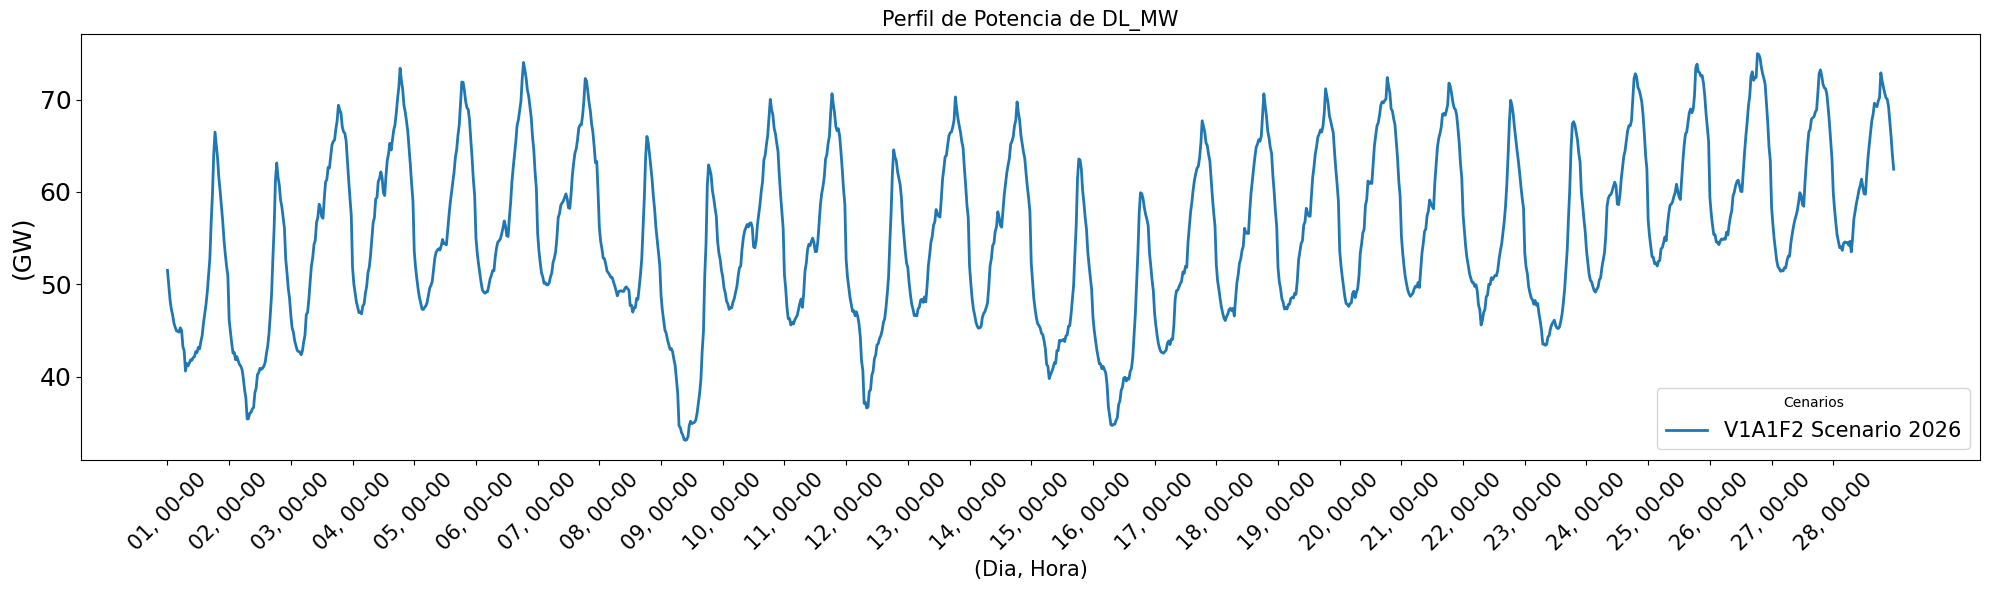

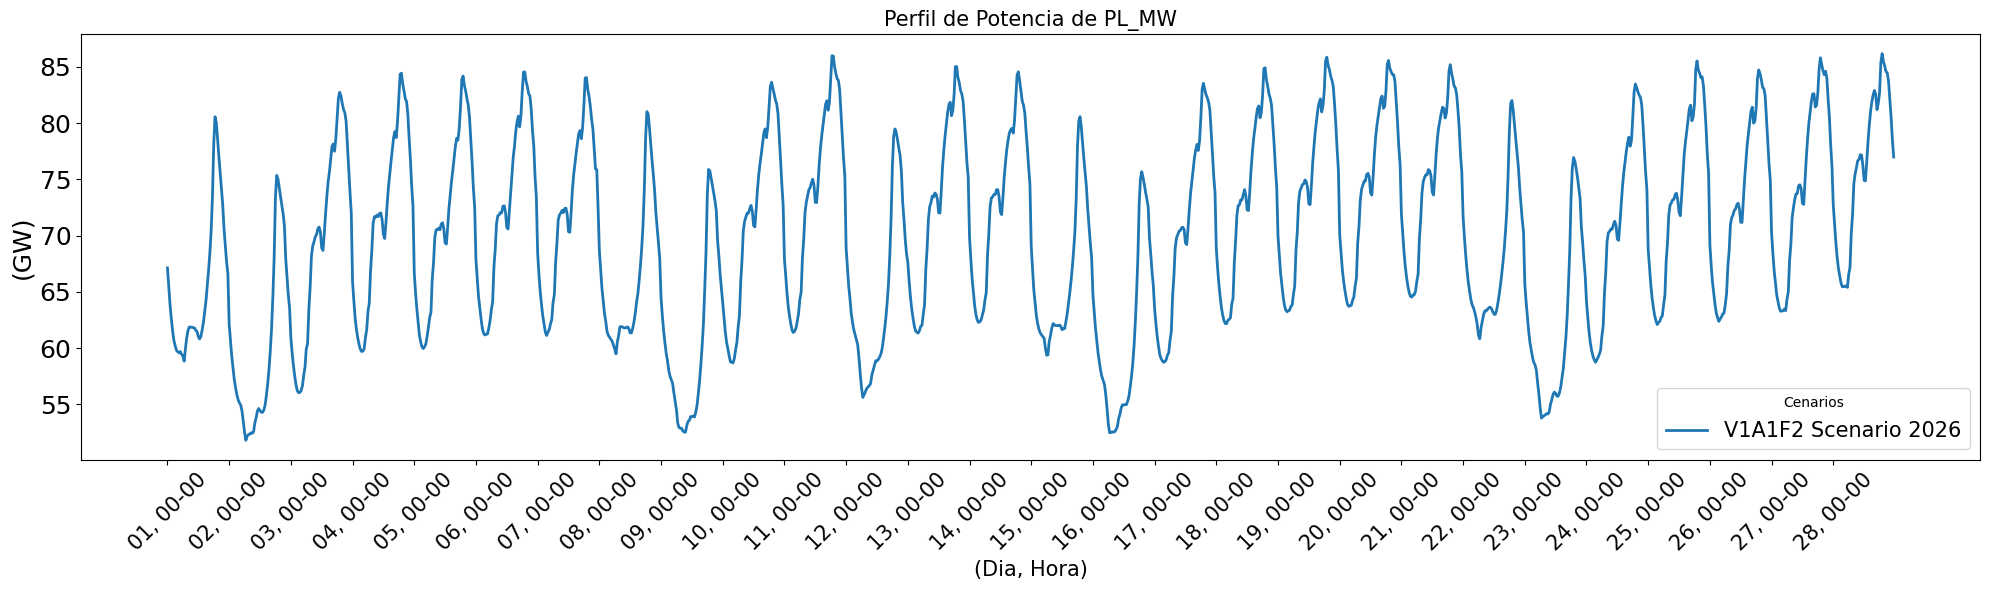

In [17]:
def plot_potencia_perfil(df_resultado, df_data, column, ylim = None, markers=True,):

    df = df_resultado.merge(df_data,on=['Dia','Hora', 'Cenario'], how='left')
    df[column] = df[column]/1000
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=df, x='Dia_Hora', y=column, hue='Cenario', markers=markers, lw = 2)
    plt.xlabel('(Dia, Hora)', fontsize = 15)
    plt.ylabel('(GW)', fontsize = 18)
    plt.title(f'Perfil de Potencia de {column}', fontsize = 15)

    value = int(df['Dia_Hora'].unique().shape[0] / 28)
    selected_ticks = df[df['Cenario'] == df['Cenario'].unique()[0]].iloc[::value]['Dia_Hora']
    plt.xticks(selected_ticks, rotation=45, fontsize=15)
    plt.tick_params(axis='y', labelsize=18)
    plt.legend(title='Cenarios', fontsize = 15)
    if ylim != None:
        plt.ylim(ylim)
    plt.tight_layout()
    plt.show()

plot_potencia_perfil(df_mask, DF_complete_PO, 'DL_MW', markers=False)
plot_potencia_perfil(df_mask, DF_complete_PO, 'PL_MW', markers=False)

In [18]:
DF_complete_PO['DL_MW'].max()

74971.144

In [19]:
# # import libraries
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# plt.style.use(['unhcrpyplotstyle','area'])

# #load and reshape the data
# df = pd.read_csv('https://raw.githubusercontent.com/GDS-ODSSS/unhcr-dataviz-platform/master/data/change_over_time/area_stacked.csv')
# df = df.pivot_table(index='months', columns='funding_type', values='funding_million', sort=False)
# df = df.reset_index()

# #compute data for plotting
# x = df['months']
# y1 = df['Earmarked']
# y2 = df['Softly earmarked']
# y3 = df['Tightly earmarked']
# y4 = df['Unearmarked']

# #plot the chart
# fig, ax = plt.subplots()
# ax.stackplot(x, y1, y2, y3, y4, labels = ['Earmarked', 'Softly earmarked', 'Tightly earmarked', 'Unearmarked'])

# #set chart legend
# ax.legend(loc=(0,1.05), ncol=4)

# #set chart title
# ax.set_title('Evolution of funding in West Africa region | 2020', pad=50)

# #set y-axis label
# ax.set_ylabel('USD millions')

# #set y-axis limit
# yl = plt.ylim(0,500)

# #set chart source and copyright
# plt.annotate('Source: UNHCR Refugee Data Finder', (0,0), (0, -25), xycoords='axes fraction', textcoords='offset points', va='top', color = '#666666', fontsize=9)
# plt.annotate('©UNHCR, The UN Refugee Agency', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top', color = '#666666', fontsize=9)

# #adjust chart margin and layout
# fig.tight_layout()

# #show chart
# plt.show()

In [20]:
# def stacklineplot(df, scenario):
#     df.reset_index(inplace=True)
#     traces = []
#     cumulative_sum = 0
    
#     # Define a color palette
#     color_palette = [
#         "#1f77b4",  # blue
#         "#ff7f0e",  # orange
#         "#2ca02c",  # green
#         "#d62728",  # red
#         "#9467bd",  # purple
#         "#8c564b",  # brown
#         "#e377c2",  # pink
#         "#7f7f7f",  # gray
#         "#bcbd22",  # lime
#         "#17becf"   # cyan
#     ]
    
#     for idx, column in enumerate(df.columns[2:]):  # Exclude 'Dia' and 'Hora' columns
#         trace = go.Scatter(
#             x=df.index,  # Assuming 'Hora' is the time column
#             y=df[column] + cumulative_sum,
#             mode='lines',
#             name=column.split('_')[-1],  # Extract the power source name
#             opacity=0.8,
#             fill='tonexty',
#             hoverinfo='x+y',  # Show both x and y values when hovering
#             line=dict(color=color_palette[idx % len(color_palette)])  # Use color from palette
#         )
#         traces.append(trace)
#         cumulative_sum += df[column]

#     # Create the plot
#     fig = go.Figure(traces)
#     fig.update_layout(
#         title="Power Generation by Source for " + scenario,
#         xaxis_title="Operation Points",
#         yaxis_title="(MW)",
#         legend_title="Generation Type",
#         plot_bgcolor='white',
#         width=1500,  # Width of the figure in pixels
#         height=500,  # Height of the figure in pixels
#         xaxis=dict(tickfont=dict(size=18)),  # Adjust x-axis label font size
#         yaxis=dict(tickfont=dict(size=18))   # Adjust y-axis label font size
#     )
#     fig.show()

# def pieplot(etiquetas, valores, explode, title):

#     def custom_autopct(pct, valores):
#         # return f"{pct:.1f}%\n({float(pct/100 * sum(valores)):.2f}TWh)"
#         return f"{pct:.1f}%"
    
#     colores = ["#4169E1", "#FF6347", "#90EE90", "#4B0082", "#FFA500", "#FFC0CB"]
#     # Create the pie chart
#     plt.figure(figsize=(6, 6))  # Adjust figure size
#     plt.pie(valores, labels=etiquetas, colors=colores, autopct=lambda pct: custom_autopct(pct, valores), explode=explode,
#             wedgeprops=dict(width=0.7, edgecolor='w'))  # Adjust slice width and edge color

#     # Title and Legend
#     plt.title("Generated Energy in the month - " + title, fontsize=12)  # Customize title
#     # plt.legend(etiquetas, loc="best")
#     plt.axis('equal')  # Equal aspect ratio ensures a circular chart
#     # Display the chart
#     plt.show()

# if Analise_GenbySource:

#     DFF_POT = DATA['df_ger_reg_concat'].drop(columns='REG').groupby(by=['Dia', 'Hora', 'Cenario']).sum()
#     DFF_POT_REG = DATA['df_ger_reg_concat'].set_index(['Dia','Hora','REG','Cenario'])
#     for scenario in dic_cenarios.keys():
#         objt = DFF_POT.loc[:,:,scenario][['PG_SOL','PG_BIO','PG_EOL','PG_UHE', 'PG_UTE',]].sum()#*0.5 #/1000000TWh
#         labels = objt.index
#         values = objt.values
#         data_ = DFF_POT.loc[:,:,scenario][['PG_UHE', 'PG_UTE', 'PG_SOL','PG_BIO','PG_EOL',]]
#         pieplot(labels,values, (0, 0, 0.0, 0, 0), scenario)
#         stacklineplot (data_, scenario)


#     fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
#     for idx, column in enumerate(['PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL']):
#         data_to_plot = []
#         for scenario in dic_cenarios.keys():
#             dff = DFF_POT.loc[:, :, scenario]
#             data_to_plot.append(dff[column] / dff['PL_MW']*100)
#         ax = axes[idx//2, idx%2]
#         ax.boxplot(data_to_plot, labels=dic_cenarios.keys())
#         ax.set_title(f"{column}/PL_MW")
#         ax.set_xlabel("Scenarios")
#         ax.set_ylabel('%')
#         ax.grid(True)

#     plt.tight_layout()
#     plt.show()

# Analise de Tensão 1

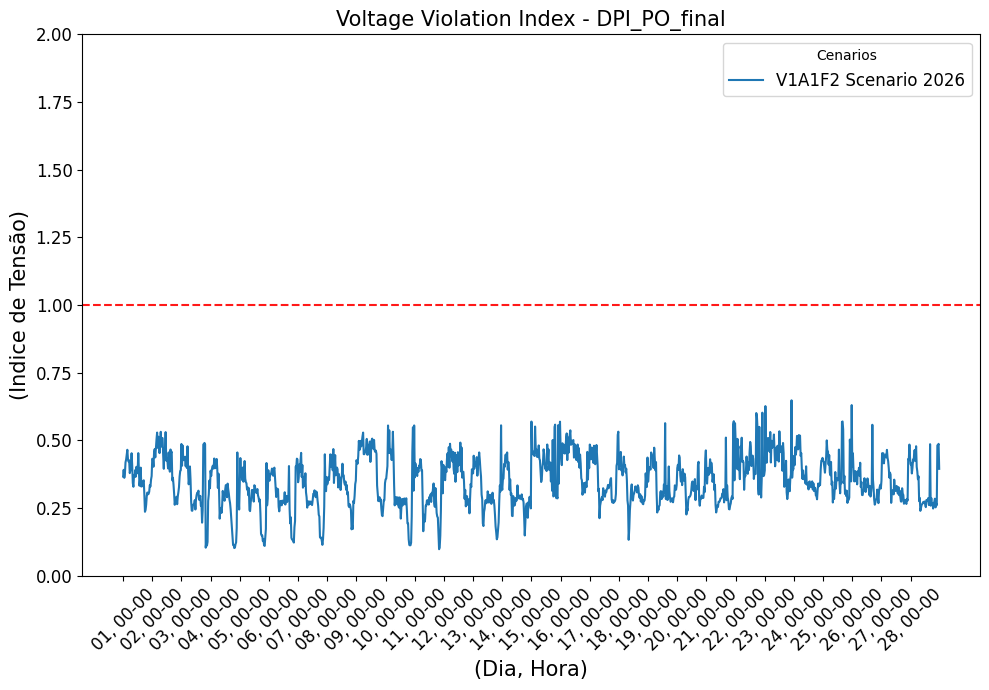

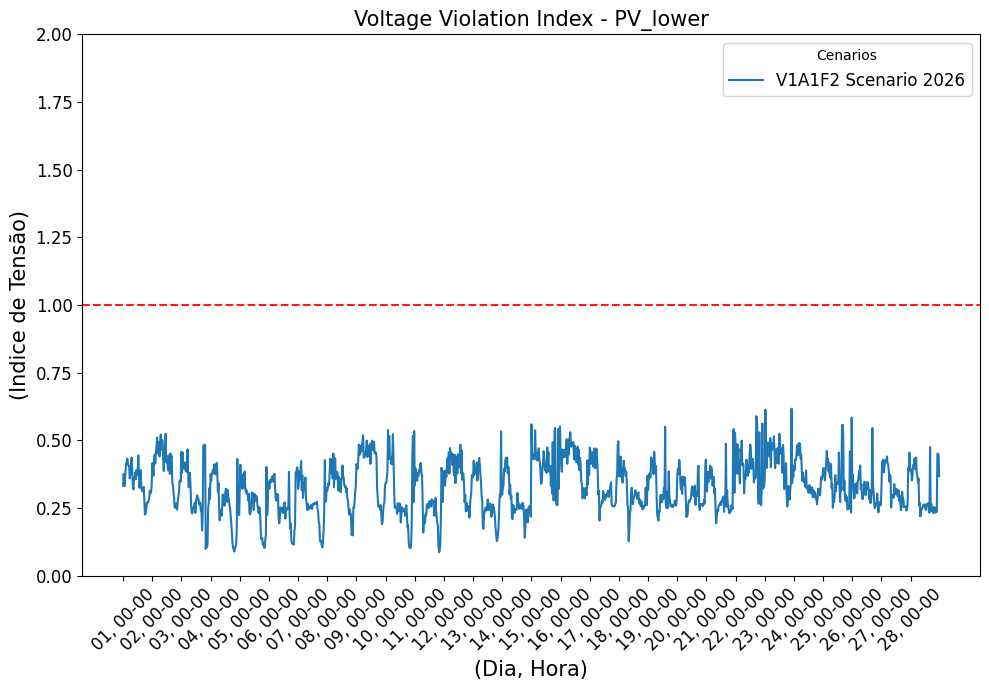

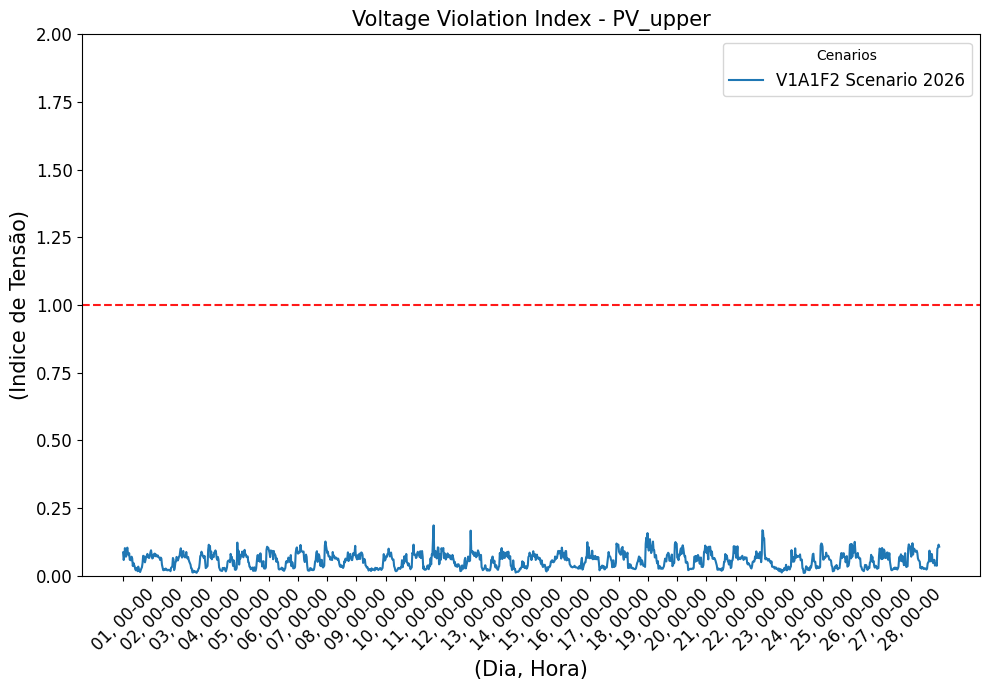

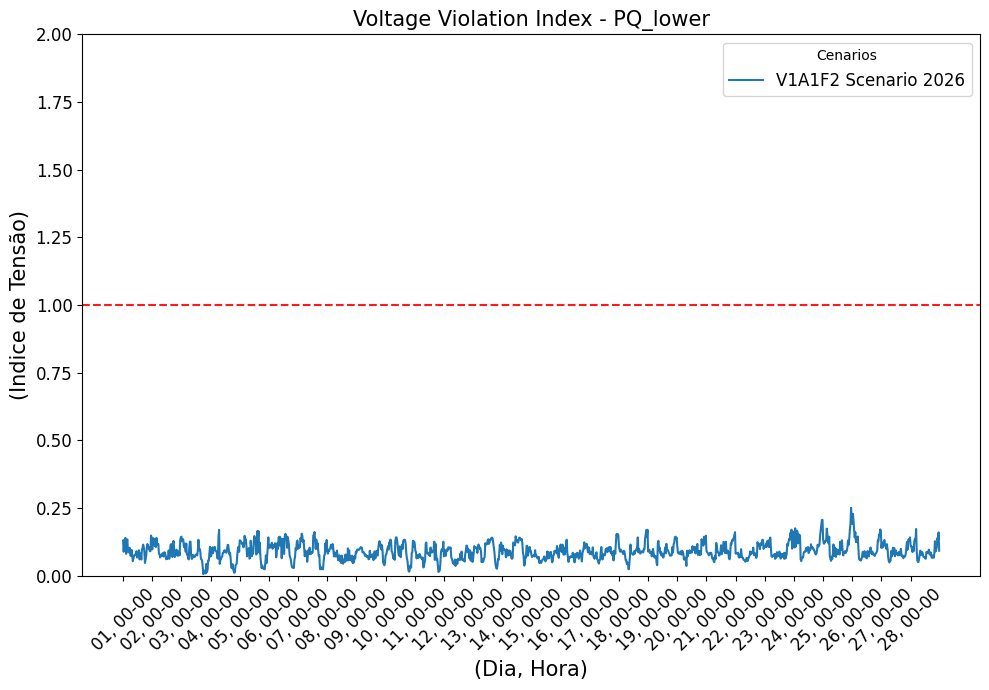

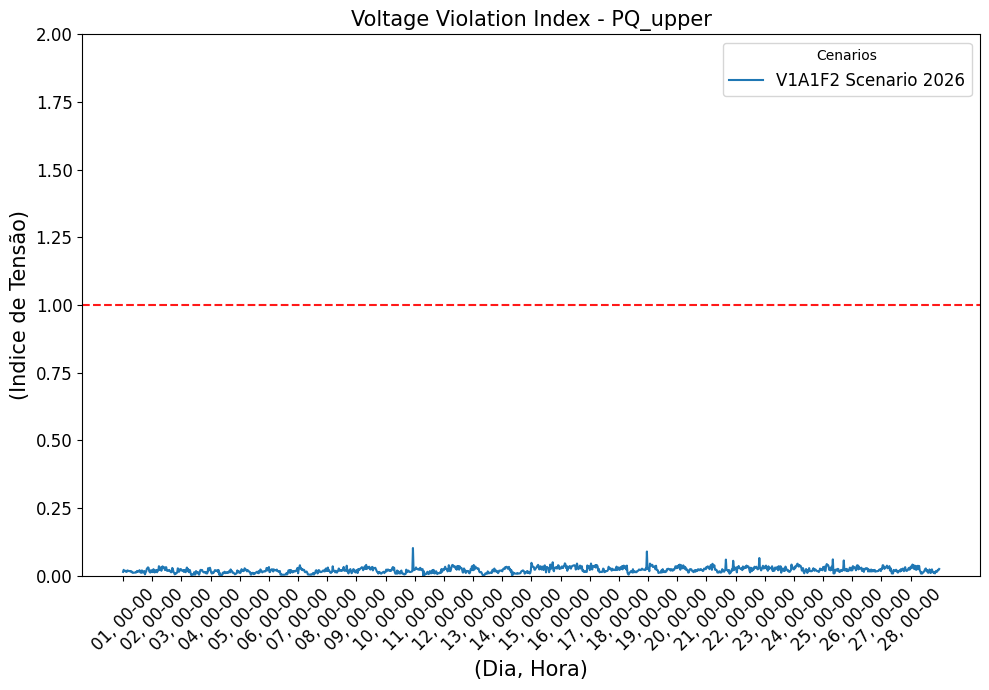

In [21]:
def plot_indice_perfil(df_resultado, df_data, column, ylim = None, markers=True,):

    df = df_resultado.merge(df_data,on=['Dia','Hora', 'Cenario'], how='left')
    df = df[['Dia_Hora','Cenario' ,  column]]

    # Plotting
    plt.figure(figsize=(10, 7))
    # sns.lineplot(data=F_ONS_melted, x='Dia_Hora', y='value', hue='Fluxos', style='Fluxos', markers=True)
    sns.lineplot(data=df, x='Dia_Hora', y=column, hue='Cenario', style='Cenario', markers=markers)
    plt.xlabel('(Dia, Hora)', fontsize = 15)
    plt.ylabel('(Indice de Tensão)', fontsize = 15)
    plt.title(f'Voltage Violation Index - {column}', fontsize = 15)

    value = int(df['Dia_Hora'].unique().shape[0] / 28)
    selected_ticks = df[df['Cenario'] == df['Cenario'].unique()[0]].iloc[::value]['Dia_Hora']
    plt.xticks(selected_ticks, rotation=45, fontsize=12)
    plt.tick_params(axis='y', labelsize=12)

    # plt.xlim(selected_ticks.iloc[0], selected_ticks.iloc[-1])
    plt.legend(title='Cenarios', fontsize = 12)
    # Agregar la línea horizontal en el valor cero del eje y
    plt.axhline(1, color='red', linestyle='--' ,  alpha=0.9)
    if ylim != None:
        plt.ylim(ylim)
    plt.tight_layout()
    # plt.grid()
    plt.show()

if Analise_Tensão:
    # plt.figure(figsize=(20, 7))
    # plot_perfil_pot(dfs['Index_PO'], columna='DPI_PO_final', ylbl='Indice (pu)', titulo='Indice de Violação de Tensão do Ponto de Operação', day=True, otherplot=True)
    # plt.axhline(1, color='red', linestyle='--' ,  alpha=0.9)
    # plt.show()
    plot_indice_perfil(df_mask, pd.concat(dfs['Index_PO'], axis=0), 'DPI_PO_final',markers=False, ylim=[0,2])
    for column in DATA['df_indice_group'].columns:
        plot_indice_perfil(df_mask, DATA['df_indice_group'], column, markers=False, ylim=[0,2])

In [22]:
def boxplot_voltage(df, clase, titulo, xlbl, ylim=None):
    # Apply matplotlib styles
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    plt.style.use("ggplot")

    # Create seaborn boxplot with customizations
    plt.figure(figsize=(12, 4))
    ax = sns.boxplot(data=df, x=clase, y="MODV_PU", hue=clase, width=0.8, linewidth=1.5, palette="mako",flierprops={'markerfacecolor': 'gray', 'marker': 'o'},legend=False, showfliers = True)

    # Customize axes spines
    border_color = 'black'
    linewidth = 1.2
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)

    # Customize the boxplot elements
    for cap in ax.artists:
        cap.set_edgecolor(border_color)
        cap.set_facecolor('white')

    for median in ax.lines:
        median.set_color('darkblue')
        median.set_linewidth(1.5)
    
    plt.ylabel('Tensão (p.u)', fontsize=16, color ='black')
    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=12, color ='black')
    plt.legend(fontsize = 15, loc='upper left')
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    # plt.legend(title='Cenário', loc='best', fontsize=15)
    plt.tick_params(axis='x', colors='black',labelsize=15, rotation = 0)  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    # Add horizontal lines
    plt.axhline(1.10, color='red', linestyle='--', alpha=0.9)
    plt.axhline(0.90, color='red', linestyle='--', alpha=0.9)
    # Set y-axis limits if specified
    if ylim is not None:
        plt.ylim(ylim)
    # Display plot
    plt.show()

def boxplot_(df,Variable, clase, titulo, xlbl, ylbl, ylim = None, hue="Cenario"):

    # Apply matplotlib styles
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    plt.style.use("ggplot")

    # Create seaborn boxplot with customizations
    plt.figure(figsize=(15, 8))
    ax = sns.boxplot(data=df, x=clase, y=Variable, hue="Cenario", width=0.8, linewidth=1.5, palette="mako",flierprops={'markerfacecolor': 'gray', 'marker': 'o'})

    # Customize axes spines
    border_color = 'black'
    linewidth = 1.2
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)

    # Customize the boxplot elements
    for cap in ax.artists:
        cap.set_edgecolor(border_color)
        cap.set_facecolor('white')

    for median in ax.lines:
        median.set_color('darkblue')
        median.set_linewidth(1.5)
    
    # Add titles and labels
    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15, color ='black')
    plt.ylabel(ylbl, fontsize=15, color ='black')
    plt.tick_params(axis='both', labelsize=15)
    # plt.legend(fontsize = 15, loc='upper left')
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    plt.legend(title='Scenarios', loc='best', fontsize=13)
    plt.tick_params(axis='x', colors='black',labelsize=12, rotation = 30)  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    
    plt.yticks(range(-5000, 20000, 2500))


    # Set y-axis limits if specified
    if ylim is not None:
        plt.ylim(ylim)

    # Display plot
    plt.show()

In [23]:
# mask_inseguros = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 1).any(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

# mask_inseguros = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] <= 0.2).all(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

mask_inseguros = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 0.2).any(axis=1)]
mask_inseguros = mask_inseguros.loc[(mask_inseguros[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] <= 1).all(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

df_ger = pd.concat(dfs['ger'], axis=0)
df_ger = df_ger.set_index('REG').rename(index=regionmap, level='REG').reset_index()
df_nt = pd.concat(dfs['nt'], axis=0)
df_nt = df_nt.set_index('REG').rename(index=regionmap, level='REG').reset_index()

filtro1 = (df_ger[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(mask_inseguros))
df_filt_ger = df_ger[filtro1]
filtro2 = (df_nt[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(mask_inseguros))
df_filt_nt = df_nt[filtro2]

# mask_inseguros = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/critical_code4_10.csv').rename(columns={'OP':'key'})
# df_filt_ger = mask_inseguros.merge(df_ger[df_ger['Cenario'] == 'V2A2F2 2026'], on='key', how='left')
# df_filt_nt = mask_inseguros.merge(df_nt[df_nt['Cenario'] == 'V2A2F2 2026'], on='key', how='left')

df_complete = pd.concat([df_filt_nt, df_filt_ger], axis=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


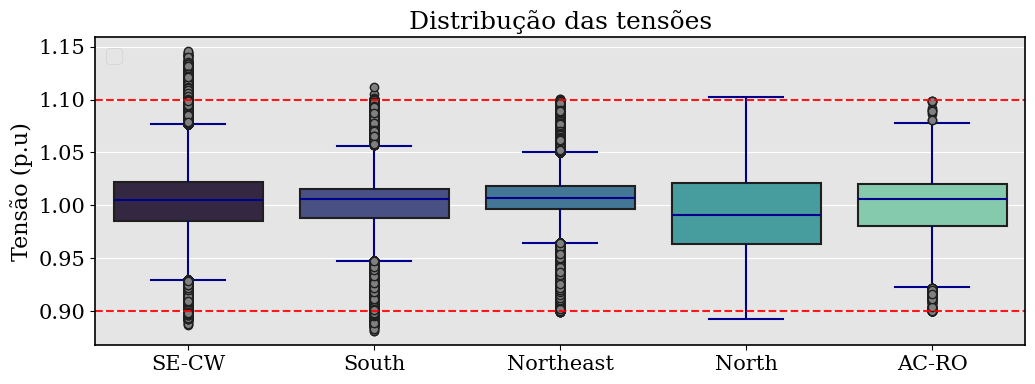

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


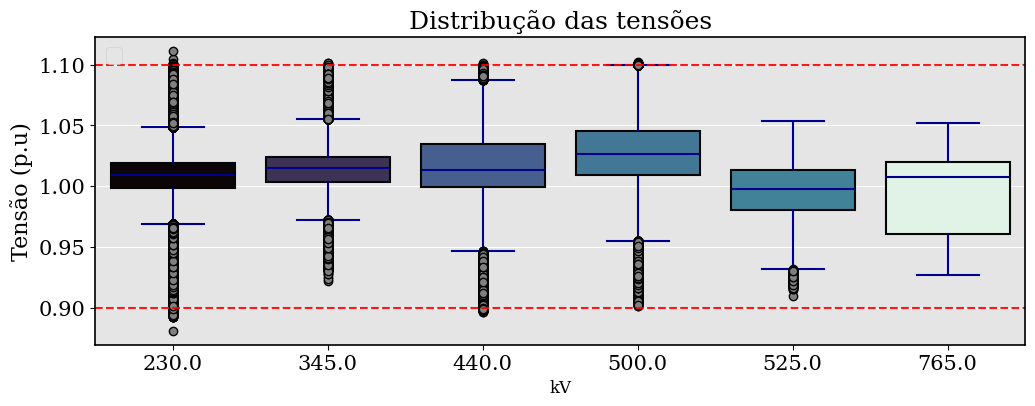

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


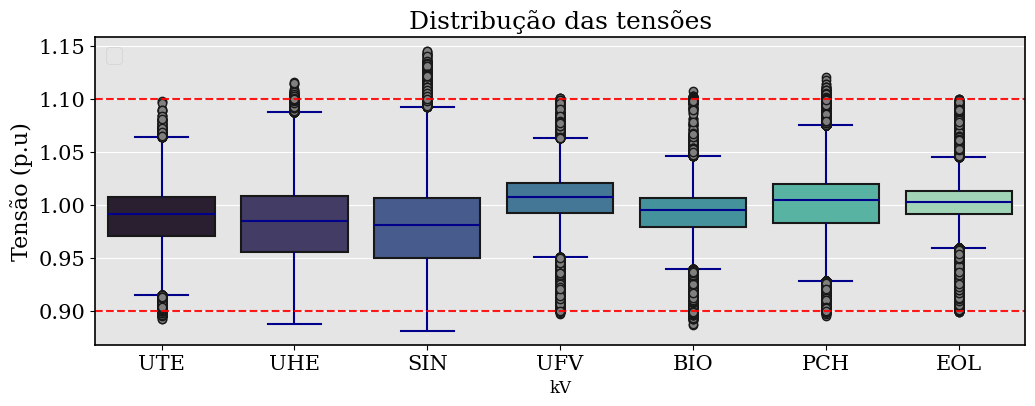

In [24]:
# boxplot_voltage(df_complete[df_complete['Cenario'].isin(['V2A2F2 2026','V2A2F5 2026'])], clase = "REG", titulo = 'Distribução das tensões - P.O. Inseguro', xlbl = '')
# boxplot_voltage(df_filt_nt[df_filt_nt['Cenario'].isin(['V2A2F2 2026','V2A2F5 2026'])], clase = "VBASEKV", titulo = 'Distribução das tensões - P.O. Inseguro', xlbl = 'kV')

boxplot_voltage(df_complete, clase = "REG", titulo = 'Distribução das tensões', xlbl = '')
boxplot_voltage(df_filt_nt, clase = "VBASEKV", titulo = 'Distribução das tensões', xlbl = 'kV')
boxplot_voltage(df_filt_ger, clase = "Gen_Type", titulo = 'Distribução das tensões', xlbl = 'kV')

In [25]:
print('O numero de pontos Inseguros com Violação de tensão são: ', mask_inseguros.shape[0])

O numero de pontos Inseguros com Violação de tensão são:  1264


In [26]:
# reg = 'Nordeste'
# tg = 230
# voltage_lev = df_nt[(df_nt['REG']==reg)]['VBASEKV'].unique()
# print(voltage_lev)
# total = df_nt[(df_nt['REG']==reg)].groupby(by=['VBASEKV','BUS_ID']).count().loc[tg].shape[0]
# # vvbuses = df_filt_nt[(df_filt_nt['MODV_PU']>1.10) & (df_filt_nt['REG']==reg) & (df_filt_nt['Cenario'] == 'V2A2F5 2026')].groupby(by=['VBASEKV','BUS_ID']).count().loc[tg].shape[0]
# vvbuses = df_filt_nt[(df_filt_nt['MODV_PU']>1.1) & (df_filt_nt['REG']==reg) & (df_filt_nt['Cenario'] == 'V2A2F5 2026')].groupby(by=['VBASEKV','BUS_ID']).count().loc[tg].shape[0]
# print(total)
# print(vvbuses)
# print(vvbuses/total*100)
# # # ===============================================================================================
# tg = 'SIN'
# voltage_lev = df_ger[(df_ger['REG']==reg)]['Gen_Type'].unique()
# print(voltage_lev)
# total = df_ger[(df_ger['REG']==reg)].groupby(by=['Gen_Type','BUS_ID']).count().loc[tg].shape[0]
# vvbuses = df_filt_ger[(df_filt_ger['MODV_PU']>1.1) & (df_filt_ger['REG']==reg) & (df_filt_ger['Cenario'] == 'V2A2F2 2026')].groupby(by=['Gen_Type','BUS_ID']).count().loc[tg].shape[0]

# print(total)
# print(vvbuses)
# print(vvbuses/total*100)

## Read Voltage Stability Data and see the electrical features

In [27]:
# CDVInst = ['D_11_H_02-00',
#             'D_12_H_11-00',
#             'D_12_H_16-30',
#             'D_15_H_09-30',
#             'D_21_H_00-30',
#             'D_5_H_11-00',
#             'D_9_H_15-30'
#             ]

CDVInst = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/critical_code4_10.csv')['OP'].values
# filtro = dfs['Index_PO'][0][['Dia','Hora']].apply(tuple, axis=1).isin(CDVInst)

filtro1 = (df_ger['key'].isin(CDVInst))
df_ger.loc[filtro1,'Estb. Angular'] = 'Criticos'
df_ger.loc[~filtro1,'Estb. Angular'] = 'Normais'
df_filt_ger_inst = df_ger[filtro1]
filtro2 = (df_nt['key'].isin(CDVInst))
df_nt.loc[filtro2,'Estb. Angular'] = 'Criticos'
df_nt.loc[~filtro2,'Estb. Angular'] = 'Normais'
df_filt_nt_inst = df_nt[filtro2]

# df_complete_inst = pd.concat([df_filt_ger_inst, df_filt_nt_inst], axis=0)
# boxplot_voltage(df_complete_inst[df_complete_inst['Cenario']=='V2A2F2 Scenario 2026'], clase = "REG", titulo = 'Distribução das tensões', xlbl = 'Region')

In [28]:
# boxplot_(df_ger[df_ger['Cenario']=='V2A2F2 Scenario 2026'],'MODV_PU', clase = "Gen_Type", hue='Estb. Angular', titulo = 'Barras Geração SIN', xlbl = 'Type of Generation',ylbl ='p.u')
# boxplot_(df_ger[df_ger['Cenario']=='V2A2F2 Scenario 2026'],'MODV_PU', clase = "REG", hue='Estb. Angular', titulo = 'Barras Geração SIN', xlbl = 'Região',ylbl ='p.u')

# boxplot_(df_ger[df_ger['Cenario']=='V2A2F2 Scenario 2026'],'PG_MW', clase = "Gen_Type", hue='Estb. Angular', titulo = 'Barras Geração SIN', xlbl = 'Type of Generation',ylbl ='(MW)',ylim=[-10,500])
# boxplot_(df_ger[df_ger['Cenario']=='V2A2F2 Scenario 2026'],'PG_MW', clase = "REG", hue='Estb. Angular', titulo = 'Barras Geração SIN', xlbl = 'Região',ylbl ='(MW)',ylim=[-10,300])

# boxplot_(df_ger[df_ger['Cenario']=='V2A2F2 Scenario 2026'],'QG_MVAR', clase = "Gen_Type", hue='Estb. Angular', titulo = 'Barras Geração SIN', xlbl = 'Type of Generation',ylbl ='(MVAR)',ylim=[-100,100])
# boxplot_(df_ger[df_ger['Cenario']=='V2A2F2 Scenario 2026'],'QG_MVAR', clase = "REG", hue='Estb. Angular', titulo = 'Barras Geração SIN', xlbl = 'Região',ylbl ='(MVAR)',ylim=[-100,100])

In [29]:
# boxplot_voltage(df_filt_ger_inst[df_filt_ger_inst['Cenario']=='V2A2F2 Scenario 2026'], clase = "Gen_Type", titulo = 'Distribução das tensões Barras Geração SIN', xlbl = 'Type of Generation')
# boxplot_voltage(df_filt_ger_inst[df_filt_ger_inst['Cenario']=='V2A2F2 Scenario 2026'], clase = "REG", titulo = 'Distribução das tensões Barras Geração SIN', xlbl = 'Região')

# boxplot_(df_filt_ger_inst[df_filt_ger_inst['Cenario']=='V2A2F2 Scenario 2026'],'PG_MW', clase = "Gen_Type", titulo = 'Barras Geração SIN', xlbl = 'Type of Generation',ylbl ='(MVW)',ylim=[-10,600])
# boxplot_(df_filt_ger_inst[df_filt_ger_inst['Cenario']=='V2A2F2 Scenario 2026'],'PG_MW' ,clase = "REG", titulo = 'Barras Geração SIN', xlbl = 'Região',ylbl ='(MVW)',ylim=[-10,600])

# boxplot_(df_filt_ger_inst[df_filt_ger_inst['Cenario']=='V2A2F2 Scenario 2026'],'QG_MVAR', clase = "Gen_Type", titulo = 'Barras Geração SIN', xlbl = 'Type of Generation',ylbl ='(MVAR)',ylim=[-200,200])
# boxplot_(df_filt_ger_inst[df_filt_ger_inst['Cenario']=='V2A2F2 Scenario 2026'],'QG_MVAR' ,clase = "REG", titulo = 'Barras Geração SIN', xlbl = 'Região',ylbl ='(MVAR)',ylim=[-200,200])

# boxplot_(df_filt_ger_inst[df_filt_ger_inst['Cenario']=='V2A2F2 Scenario 2026'],'ANGV_DEG', clase = "Gen_Type", titulo = 'Barras Geração SIN', xlbl = 'Type of Generation',ylbl ='Desvio Ang º',ylim=[-200,200])
# boxplot_(df_filt_ger_inst[df_filt_ger_inst['Cenario']=='V2A2F2 Scenario 2026'],'ANGV_DEG' ,clase = "REG", titulo = 'Barras Geração SIN', xlbl = 'Região',ylbl ='Desvio Ang º',ylim=[-200,200])


In [30]:
# dicusinas = {
#     'Jirau': [7051, 7061],
#     'S_Antonio': [7050, 7062, 7064],
#     'UHE_ACRO_230': [6888, 6892, 6891],
#     'Tucurui': [6419, 6420, 6422, 6424, 6425],
#     'B_Monte': [6729],
#     'Itaipu_50': [1100],
#     'Itaipu_60': [1107],
#     'I_Solt': [501],
#     'Angra I': [10],
#     'Angra II': [11],
#     'TPires': [4492],
#     'S_Mesa': [36],
#     'XINGO':[5061],
#     'Furnas' : [16]
# }

# variable = [('MODV_PU','Tensão (p.u)',0.90,1.10), ('PG_MW','(MW)',0, 0), ('QG_MVAR', 'MVAR',0, 0), (' Reserve','MW',0,0)]
# # Assuming 'dicusinas' and 'variable' are defined somewhere in your code
# for us, buses in dicusinas.items():
#     fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
#     for idx, (var, ylbl, lim1, lim2) in enumerate(variable):
#         ax = axes[idx]  # Get the current subplot
#         sns.boxplot(
#             data=df_ger[(df_ger['Cenario'] == 'V2A2F2 Scenario 2026') & (df_ger['BUS_ID'].isin(buses))],
#             x='Estb. Angular', y=var, hue='Estb. Angular', width=.9, linewidth=1, gap=.1, fill=False, ax=ax
#         )
#         ax.set_xlabel(us, fontsize=10)
#         ax.set_ylabel(ylbl, fontsize=10)
#         ax.tick_params(axis='both', labelsize=8)
#         ax.axhline(lim2, color='red', linestyle='--', alpha=0.9)
#         ax.axhline(lim1, color='red', linestyle='--', alpha=0.9)

#     plt.savefig(f'Analises Pontos Inestaveis/{us}_combined_plot.jpg')  # Save the combined plot
#     plt.show()  # Show the plot

### Index Correlation with Voltage Instability box plot

In [31]:
filtro1 = DATA['df_DPI'].index.get_level_values('key').isin(CDVInst)
DATA['df_DPI'].loc[filtro1,'Estb. Angular'] = 'Criticos'
DATA['df_DPI'].loc[~filtro1,'Estb. Angular'] = 'Normais'

# dataindexS1 = pd.melt(DATA['df_DPI'].loc[:,:,:,'V2A2F2 Scenario 2026'], id_vars=['Estb. Angular'], value_vars=DATA['df_DPI'].columns[30:])

# columns = ['DPI_inf_AC-RO_PCH', 'DPI_sup_AC-RO_PCH', 'DPI_inf_AC-RO_SIN',
#        'DPI_sup_AC-RO_SIN', 'DPI_inf_AC-RO_UHE', 'DPI_sup_AC-RO_UHE',
#        'DPI_inf_AC-RO_UTE', 'DPI_sup_AC-RO_UTE']

# boxplot_(dataindexS1[dataindexS1['variable'].isin(columns)],'value', clase = "variable", hue='Estb. Angular', titulo = 'Indice de Violação de tensão', xlbl = 'Indice',ylbl ='p.u')
# columns = ['DPI_inf_North_EOL',
#        'DPI_sup_North_EOL', 'DPI_inf_North_SIN', 'DPI_sup_North_SIN',
#        'DPI_inf_North_UFV', 'DPI_sup_North_UFV', 'DPI_inf_North_UHE',
#        'DPI_sup_North_UHE', 'DPI_inf_North_UTE', 'DPI_sup_North_UTE',]

# boxplot_(dataindexS1[dataindexS1['variable'].isin(columns)],'value', clase = "variable", hue='Estb. Angular', titulo = 'Indice de Violação de tensão', xlbl = 'Indice',ylbl ='p.u')
# columns = ['DPI_inf_Northeast_EOL', 'DPI_sup_Northeast_EOL',
#        'DPI_inf_Northeast_SIN', 'DPI_sup_Northeast_SIN',
#        'DPI_inf_Northeast_UFV', 'DPI_sup_Northeast_UFV',
#        'DPI_inf_Northeast_UHE', 'DPI_sup_Northeast_UHE',
#        'DPI_inf_Northeast_UTE', 'DPI_sup_Northeast_UTE']

# boxplot_(dataindexS1[dataindexS1['variable'].isin(columns)],'value', clase = "variable", hue='Estb. Angular', titulo = 'Indice de Violação de tensão', xlbl = 'Indice',ylbl ='p.u')
# columns = ['DPI_inf_SE-CW_BIO',
#        'DPI_sup_SE-CW_BIO', 'DPI_inf_SE-CW_EOL', 'DPI_sup_SE-CW_EOL',
#        'DPI_inf_SE-CW_PCH', 'DPI_sup_SE-CW_PCH', 'DPI_inf_SE-CW_SIN',
#        'DPI_sup_SE-CW_SIN', 'DPI_inf_SE-CW_UFV', 'DPI_sup_SE-CW_UFV',
#        'DPI_inf_SE-CW_UHE', 'DPI_sup_SE-CW_UHE', 'DPI_inf_SE-CW_UTE',
#        'DPI_sup_SE-CW_UTE']

# boxplot_(dataindexS1[dataindexS1['variable'].isin(columns)],'value', clase = "variable", hue='Estb. Angular', titulo = 'Indice de Violação de tensão', xlbl = 'Indice',ylbl ='p.u')
# columns = ['DPI_inf_South_BIO', 'DPI_sup_South_BIO',
#        'DPI_inf_South_EOL', 'DPI_sup_South_EOL', 'DPI_inf_South_PCH',
#        'DPI_sup_South_PCH', 'DPI_inf_South_SIN', 'DPI_sup_South_SIN',
#        'DPI_inf_South_UHE', 'DPI_sup_South_UHE', 'DPI_inf_South_UTE',
#        'DPI_sup_South_UTE']

# boxplot_(dataindexS1[dataindexS1['variable'].isin(columns)],'value', clase = "variable", hue='Estb. Angular', titulo = 'Indice de Violação de tensão', xlbl = 'Indice',ylbl ='p.u')

# Analise Indice 2

In [32]:
def separaFERV_Load(df, condition, Load = False ):
    if Load == False:
        dff = df.reset_index().merge(DF_complete_PO[['PG_FERV']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PG_FERV'] > condition[0]) & (dff['PG_FERV'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])
    else:
        dff = df.reset_index().merge(DF_complete_PO[['PL_MW']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PL_MW_y'] > condition[0]) & (dff['PL_MW_y'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])   
        dff = dff.drop(columns='PL_MW_y').rename(columns={'PL_MW_x':'PL_MW'})  
    return dff

def reorder_and_filter(df, cenario, region, columns):
    df = df.reorder_levels(['Dia', 'Hora', 'Cenario', 'REG'])[columns]
    if cenario == 'all':
        if region == 'all':
            df_reordered = df
        elif region == 'PO':
            df_reordered = df
        else:
            df_reordered = df.loc[:, :, :, region]
    else:
        if region == 'all':
            df_reordered = df.loc[:, :, cenario, :]
        elif region == 'PO':
            df_reordered = df.loc[:, :, cenario]
        else:
            df_reordered = df.loc[:, :, cenario, region]
    return df_reordered

def set_column_names(datapd, df_reordered_sorted, region):
    if region == 'all':
        columns = []
        for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
            for column in df_reordered_sorted.columns:
                name = column + '_' + reg
                columns.append(str(name))
        datapd.columns = columns
    return datapd

def merge_data(datapd, df, cenario, key):
    if cenario == 'all':
        return datapd.merge(df, on=['Dia', 'Hora', 'Cenario'], how='left')
    if isinstance(cenario, list):
        return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora', 'Cenario'], how='left')
    return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora'], how='left')

def flatdataframe(df_data_completo, cenario, region, columns, ACDCflux=True, Reserva=False, IndiceGroup=False, DPI=False, InfoPO=False, PImva_reg_nt=False, PImva=False, Busfeatures = False, Vanalysis = None,Linefeatures = False):
    """
    Flattens the provided dataframe based on the specified filters and parameters.

    Parameters:
    df_data_completo (pd.DataFrame): The complete dataframe to be flattened.
    cenario (str or list): The scenario to filter by.
    region (str): The region to filter by.
    columns (list): The columns to include in the flattened dataframe.
    ACDCflux (bool): Include AC/DC flux data.
    Reserva (bool): Include reserve data.
    IndiceGroup (bool): Include index group data.
    DPI (bool): Include DPI data.
    InfoPO (bool): Include PO info.
    PImva_reg_nt (bool): Include PImva region NT data.
    PImva (bool): Include PImva data.

    Returns:
    pd.DataFrame: The flattened dataframe.
    """
    df_reordered_sorted = reorder_and_filter(df_data_completo, cenario, region, columns)

    if region == 'all' and cenario == 'all':
        lista = [[index[0], index[1], index[2]] for index in df_reordered_sorted.index]
        conjunto_filtros = set(map(tuple, lista))
        conjunto_filtros = tuple(sorted(conjunto_filtros))
        data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
        datapd = pd.DataFrame(data, index=conjunto_filtros)
    else:
        datapd = df_reordered_sorted

    datapd = set_column_names(datapd, df_reordered_sorted, region)

    if cenario == 'all':
        datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
    else:
        if isinstance(cenario, list):
            if region == 'all':
                datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
            else:
                datapd.index.set_names(['Dia', 'Hora', 'Cenario', 'REG'], inplace=True)
        else:
            datapd.index.set_names(['Dia', 'Hora'], inplace=True)

    if ACDCflux:
        datapd = merge_data(datapd, DATA['df_Inter_AC_DC'], cenario, 'AC_DC')
    if Reserva:
        datapd = merge_data(datapd, DATA['df_reserva'][[' Reserve']], cenario, 'Reserva')
    if IndiceGroup:
        datapd = merge_data(datapd, DATA['df_indice_group'], cenario, 'IndiceGroup')
    if DPI:
        datapd = merge_data(datapd, DATA['df_DPI'], cenario, 'DPI')
    # if PImva:
    #     datapd = merge_data(datapd, dfl_po[['PI_mva', 'PFI']], cenario, 'PImva')
    # if PImva_reg_nt:
    #     dff = flatdf(dfl_r_nt[['PI_mva', 'PFI']], 'VBASEKV')
    #     datapd = merge_data(datapd, dff, cenario, 'PImva_reg_nt')
    if InfoPO:
        columns = ['DL_MW', 'Jirau_MW', 'Jirau_MVAR', 'S_Antonio_MW',
       'S_Antonio_MVAR', 'Tucurui_MW', 'Tucurui_MVAR', 'B_Monte_MW', 'B_Monte_MVAR', 'Itaipu_50_MW', 'Itaipu_50_MVAR', 'Itaipu_60_MW','G_ACRO_230_MW', 'G_ACRO_230_MVAR',
       'Itaipu_60_MVAR', 'I_Solt_MW', 'I_Solt_MVAR', 'PG_FERV']
        datapd = merge_data(datapd, DF_complete_PO[columns], cenario, 'InfoPO')
    if Busfeatures:
        if Vanalysis == 'OV':
            df_aux = DATA['features_sup_pv_df'].merge(DATA['features_sup_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_sup')
            # datapd = merge_data(datapd, DATA['features_sup_pv_df'], cenario, 'features_sup').set_index(['Dia', 'Hora', 'Cenario'])
            # datapd = merge_data(datapd, DATA['features_sup_pq_df'], cenario, 'features_sup').set_index(['Dia', 'Hora', 'Cenario'])
        elif Vanalysis == 'UV':
            df_aux = DATA['features_inf_pv_df'].merge(DATA['features_inf_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_inf')
            # datapd = merge_data(datapd, DATA['features_inf_pv_df'], cenario, 'features_inf').set_index(['Dia', 'Hora', 'Cenario'])
            # datapd = merge_data(datapd, DATA['features_inf_pq_df'], cenario, 'features_inf').set_index(['Dia', 'Hora', 'Cenario'])
    if Linefeatures:
        datapd = merge_data(datapd, DATA['features_lines'], cenario, 'features_lines').set_index(['Dia', 'Hora', 'Cenario'])

    datapd.columns = datapd.columns.astype(str)
    return datapd

In [33]:
'''
============ Geração RO ================
6822: (PBUEN2PCH138) SISTEMA 138KV
6831: (ROND2-UHE003) SISTEMA 138KV
6832: (ROND2-UTE000) SISTEMA 138KV (TERMICA SEM DADOS DE GERADOR)

6888 (SA-AD1UHE003) - SISTEMA 230KV
6892 (SA-AD2UHE003) - SISTEMA 230KV
6891 (SAMU1-UHE005) - SISTEMA 230KV

6911 (T.NOR1UTE000) - SISTEMA 230KV (TERMICA SEM DADOS DE GERADOR)
6912 (T.N2-GUTE000) - SISTEMA 230KV
6913 (T.N2-VUTE000) - SISTEMA 230KV
============ COMP. SYN ================
ARIQU-SIN001
JIPAR-SIN001
============= Mostra quantas barras Com Violação tem em cada Região ==========

# df_complete[df_complete['MODV_PU']>1.10].groupby(['REG'])['BUS_ID'].unique()
# df_complete[df_complete['MODV_PU']< 0.90].groupby(['REG'])['BUS_ID'].unique()['AC-RO'].shape

#EL FLUJO DE POTENCIA REACTIVA VA DE LA MAIOR TENSIOHN A ALA MENOR TENSION
#El flujo de potencia va de la barra con angulo mas adelantado a la barra con angulo mas atrado

'''

"\n============ Geração RO ================\n6822: (PBUEN2PCH138) SISTEMA 138KV\n6831: (ROND2-UHE003) SISTEMA 138KV\n6832: (ROND2-UTE000) SISTEMA 138KV (TERMICA SEM DADOS DE GERADOR)\n\n6888 (SA-AD1UHE003) - SISTEMA 230KV\n6892 (SA-AD2UHE003) - SISTEMA 230KV\n6891 (SAMU1-UHE005) - SISTEMA 230KV\n\n6911 (T.NOR1UTE000) - SISTEMA 230KV (TERMICA SEM DADOS DE GERADOR)\n6912 (T.N2-GUTE000) - SISTEMA 230KV\n6913 (T.N2-VUTE000) - SISTEMA 230KV\n============ COMP. SYN ================\nARIQU-SIN001\nJIPAR-SIN001\n============= Mostra quantas barras Com Violação tem em cada Região ==========\n\n# df_complete[df_complete['MODV_PU']>1.10].groupby(['REG'])['BUS_ID'].unique()\n# df_complete[df_complete['MODV_PU']< 0.90].groupby(['REG'])['BUS_ID'].unique()['AC-RO'].shape\n\n#EL FLUJO DE POTENCIA REACTIVA VA DE LA MAIOR TENSIOHN A ALA MENOR TENSION\n#El flujo de potencia va de la barra con angulo mas adelantado a la barra con angulo mas atrado\n\n"

In [34]:
def plot_potencia_perfil_2(df_resultado, df_data, column1, column2, ylabel = '(MW)', ylabelrigth = '(P.U)', ylim=None, ylim2=None, markers=True):

    df = df_resultado.merge(df_data, on=['Dia','Hora', 'Cenario'], how='left')
    plt.figure(figsize=(20, 5))
    ax1 = plt.gca()  # get current axes
    for col in column1:
        sns.lineplot(data=df, x='Dia_Hora', y=col, ax=ax1, color='blue', label = col)
        # sns.lineplot(data=df, x='Dia_Hora', y=column1, hue='Cenario', style='Cenario', markers=markers, label = column1)
        
    plt.ylabel(ylabelrigth, fontsize=15)
    value = int(df['Dia_Hora'].unique().shape[0] / 28)
    selected_ticks = df[df['Cenario'] == df['Cenario'].unique()[0]].iloc[::value]['Dia_Hora']
    plt.xlabel('(Dia, Hora)', fontsize=15)
    plt.xticks(selected_ticks, rotation=45, fontsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.legend(loc='upper left', fontsize=12)
    # plt.grid(alpha = 1)
    if ylim is not None:
        plt.ylim(ylim)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    for col in column2:
        sns.lineplot(data=df, x='Dia_Hora', y=col, ax=ax2, label = col)  
        # sns.lineplot(data=df, x='Dia_Hora', y=col, ax=ax2, palette="hls", label = col)  
    # sns.lineplot(data=df, x='Dia_Hora', y=column2, hue='Cenario', style='Cenario', markers=markers, label = column2)
    ax2.set_ylabel(ylabel, fontsize=15)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelsize=12)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(visible=False)
    if ylim2 is not None:
        plt.ylim(ylim2)

    plt.tight_layout()
    plt.show()

In [35]:
# eloFozibiuna = [85, 86]
# eloPVelArarq = [7055, 7057]
# eloCPVbtbPvel = [7059, 7054]
# eloXinguTR = [8100, 9605]
# eloXinguESTR = [8100, 3010]
# Jirau = [7051, 7061]
# S_Antonio = [7050, 7062, 7064]
# S_Antontonio_ACRO = [6888, 6892, 6891]
# df_complete_t = pd.concat([df_nt, df_ger], axis=0)
# dic_cenarios.keys()

# # ====================================================================================
# # Analise Especifico por Região e grupo de barramentos, escolher o cenario de Analise a Região e as barras a analisar
# target_scenario = 'V1A1F3 Scenario 2026'
# region_ = 'AC-RO'
# buses = eloCPVbtbPvel 
# var = 'B0_MVAR'

# if buses != None:
#     dff_5 = df_complete_t[df_complete_t['BUS_ID'].isin(buses)].groupby(by=['Dia','Hora','Cenario'])[[var]].sum().merge(DATA['df_indice_group'], on=['Dia', 'Hora', 'Cenario'], how='left')
# elif buses == None:
#     dff_5 = df_complete_t.groupby(by=['Dia','Hora','Cenario'])[[var]].sum().merge(DATA['df_indice_group'], on=['Dia', 'Hora', 'Cenario'], how='left')

# DFF5 = dff_5.reset_index()

# plot_potencia_perfil_2(df_mask, DFF5[DFF5['Cenario']==target_scenario], ['PQ_upper'],[var],'(MVAR)', markers=False,)
# plot_potencia_perfil_2(df_mask, DFF5[DFF5['Cenario']==target_scenario], ['PV_upper'],[var],'(MVAR)', markers=False,)


In [36]:
cenario = 'all'
region = 'all'

columns2 = ['OV DPI_PQ', 'UV DPI_PQ', 'OV DPI_PV', 'UV DPI_PV', 'PL_MW','PG_MW','QL_MVAR','QG_MVAR','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL', 'Mvar:Losses_500down','Mvar:Losses_500up','% L1_500up','% L1_500down','Shunt_Ind', 'Shunt_Cap','key','ReservaIND', 'ReservaCAP']
# columns2 = ['key','PL_MW','PG_MW','QL_MVAR','QG_MVAR','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL', 'Mvar:Losses_500down','Mvar:Losses_500up','% L1_500up','% L1_500down','Shunt_Ind', 'Shunt_Cap']

# insecure_indices = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 0).any(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

insecure_indices = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 0.2).any(axis=1)]
insecure_indices = insecure_indices.loc[(insecure_indices[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] <= 1).all(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

filtro = Df_data_completo_reg.index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(insecure_indices)
dfanalise = Df_data_completo_reg[filtro]
dfanalise = flatdataframe(dfanalise, cenario, region, columns2, ACDCflux=True, Reserva=True, DPI=True, IndiceGroup=False, InfoPO=True, PImva_reg_nt=False, PImva=False, Busfeatures=False,Vanalysis='OV', Linefeatures=False)
dfanalise.shape

(1264, 217)

### Determinar porcetagem de pontos de operação em alarme em cada região.

In [37]:
dfanalise[dfanalise['OV DPI_PV_SE-CW']>0.2].shape[0]/insecure_indices.shape[0]*100

0.0

## Analise Indice 2.1

C:\Users\david\AppData\Local\Temp\ipykernel_25472\3376241457.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


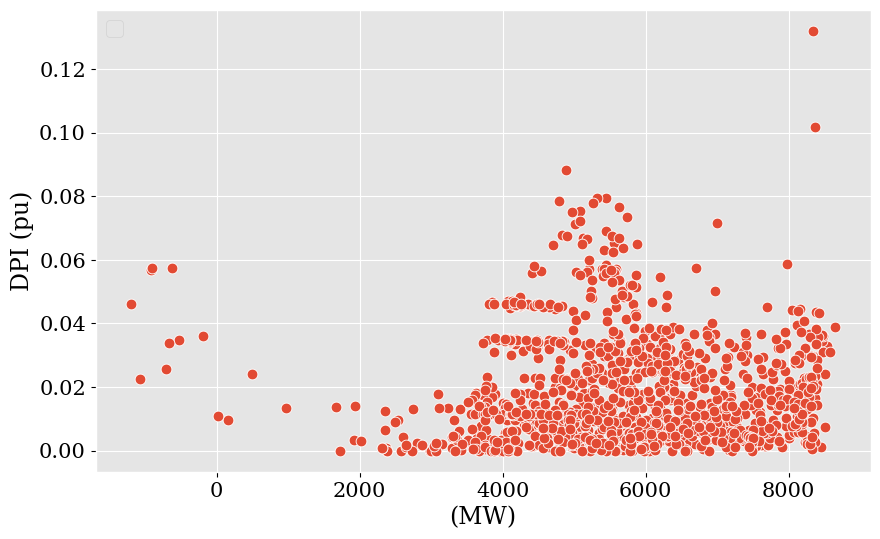

C:\Users\david\AppData\Local\Temp\ipykernel_25472\3376241457.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Indice de Correlación: -0.025792741995786593


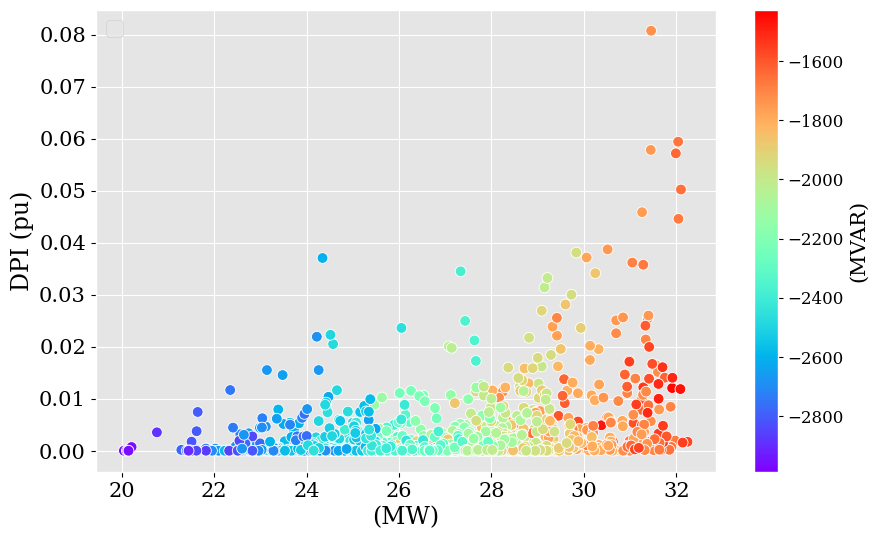

Indice de Correlación: 0.3389345115079726


In [38]:
def scatterplot_1(df, v1, v2,v3 = None, xlimites = None, ylimites = None, namedir = None):

    cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
    plt.figure(figsize=(10, 6))
    if v3 == None:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, s=60, legend=None)
    else:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, palette=cmap, hue=v3, s=60, legend=None)
        norm = mcolors.Normalize(vmin=df[v3].min(), vmax=df[v3].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', label='(MW)',)
        # Set color bar tick labels to black
        cbar.ax.yaxis.set_tick_params(color='black',labelsize=12)
        plt.setp(cbar.ax.get_yticklabels(), color='black')
        # Set the color and size of the color bar legend label
        cbar.set_label('(MVAR)', fontsize=15, color='black')

    # plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    # nometitulo = f'{namedir} Scatter plot of {v2} vs {v1}'.replace(':',' ')
    # nometitulo = f'Scatter plot of {v2} vs {v1}'.replace(':',' ')
    nometitulo = ''
    plt.title(nometitulo, fontsize = 15)
    plt.xlabel('(MW)', fontsize = 17, color ='black')
    plt.legend(fontsize = 15, loc='upper left')
    plt.ylabel('DPI (pu)', fontsize = 17, color ='black')
    # plt.axhline(1, color='red', linestyle='--', alpha=0.9)
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    plt.tick_params(axis='x', colors='black',labelsize=15, rotation = 0)  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    if xlimites != None:
        plt.xlim(xlimites)
    if ylimites != None:
        plt.ylim(ylimites)
        
    # if namedir != None:
        # nome = folderimg+'Correlações/' + namedir + nometitulo + '.svg'
        # # plt.savefig(nome)
        # nome = folderimg+'Correlações/' + namedir + nometitulo + '.png'
        # # plt.savefig(nome)
    plt.show()

    correlation = df[v1].corr(df[v2])
    print(f"Indice de Correlación: {correlation}")
    
# scatterplot(dfanalise, 'Mvar:Losses_500down_North', 'UV DPI_PV_North', 'B_Monte_MW')
# scatterplot(dfanalise, 'Elo_XINGU-SE', 'UV DPI_PV_North', 'Mvar:Losses_500down_North')
# scatterplot(dfanalise, 'Mvar:Losses_500up_South', 'UV DPI_PV_SE-CW', 'QL_MVAR_SE-CW')
# scatterplot(dfanalise, 'QL_MVAR_North', 'UV DPI_PV_SE-CW', 'PL_MW_SE-CW')

scatterplot_1(dfanalise, 'Fluxo_NE-SE','OV DPI_PV_North',)
scatterplot_1(dfanalise, '% L1_500down_Northeast','OV DPI_PV_Northeast', 'Mvar:Losses_500down_Northeast')

C:\Users\david\AppData\Local\Temp\ipykernel_25472\3376241457.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


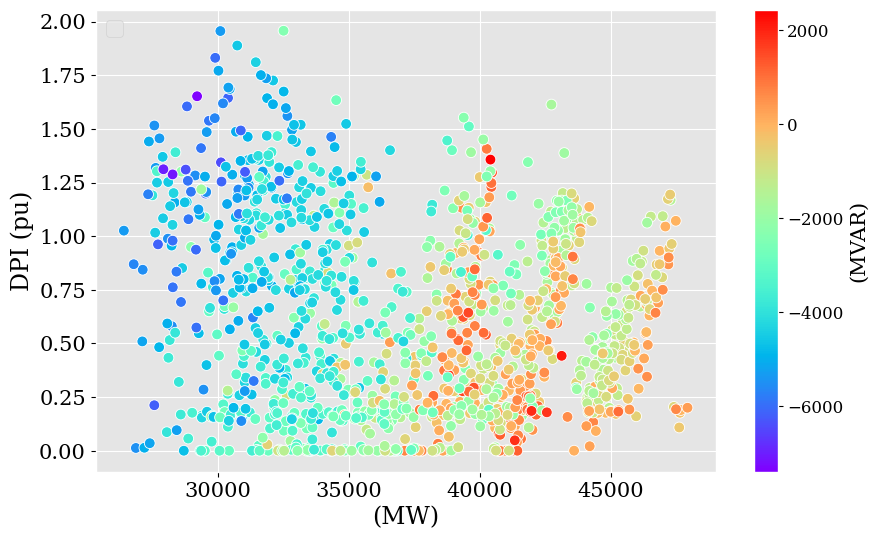

C:\Users\david\AppData\Local\Temp\ipykernel_25472\3376241457.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Indice de Correlación: -0.16994964925195458


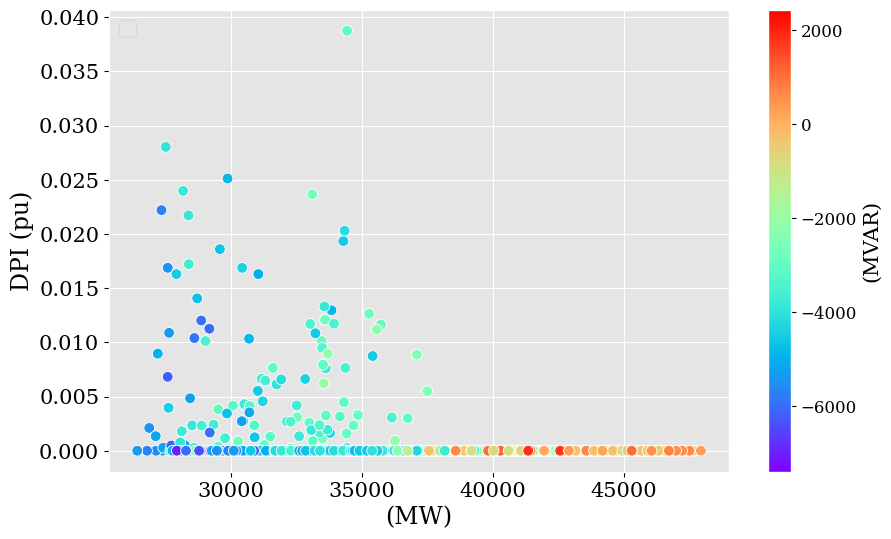

Indice de Correlación: -0.2384109430487561


In [39]:
scatterplot_1(dfanalise, 'PL_MW_SE-CW','DPI_inf_SE-CW_500.0','QG_MVAR_SE-CW')
scatterplot_1(dfanalise, 'PL_MW_SE-CW', 'DPI_sup_SE-CW_500.0', 'QG_MVAR_SE-CW')

C:\Users\david\AppData\Local\Temp\ipykernel_25472\3376241457.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


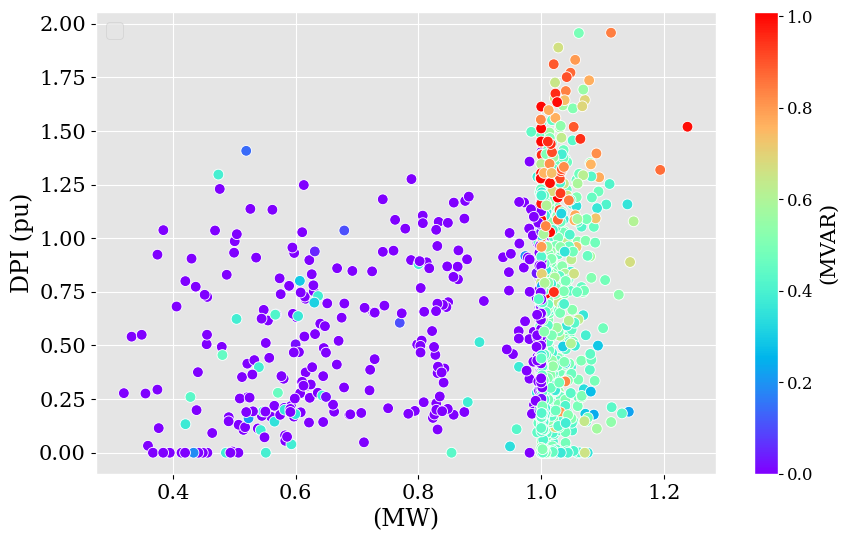

C:\Users\david\AppData\Local\Temp\ipykernel_25472\3376241457.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Indice de Correlación: 0.15918095081154962


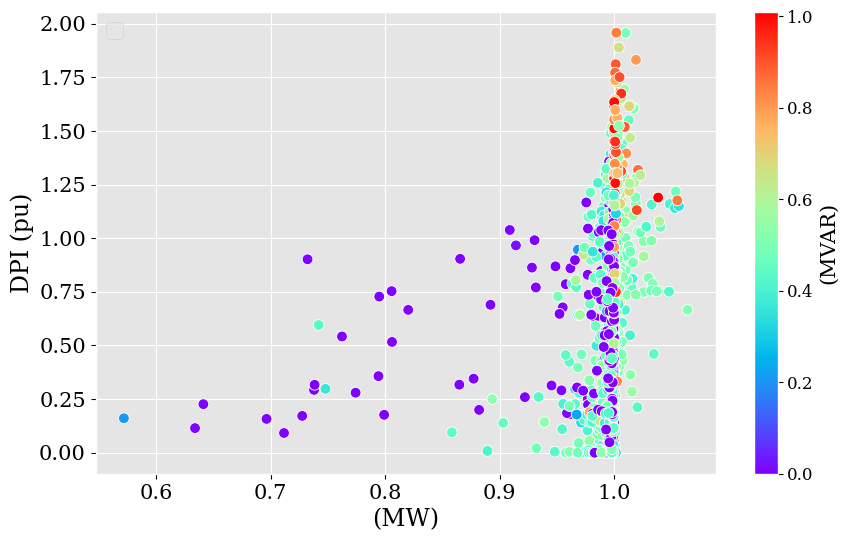

C:\Users\david\AppData\Local\Temp\ipykernel_25472\3376241457.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Indice de Correlación: 0.1814849974709229


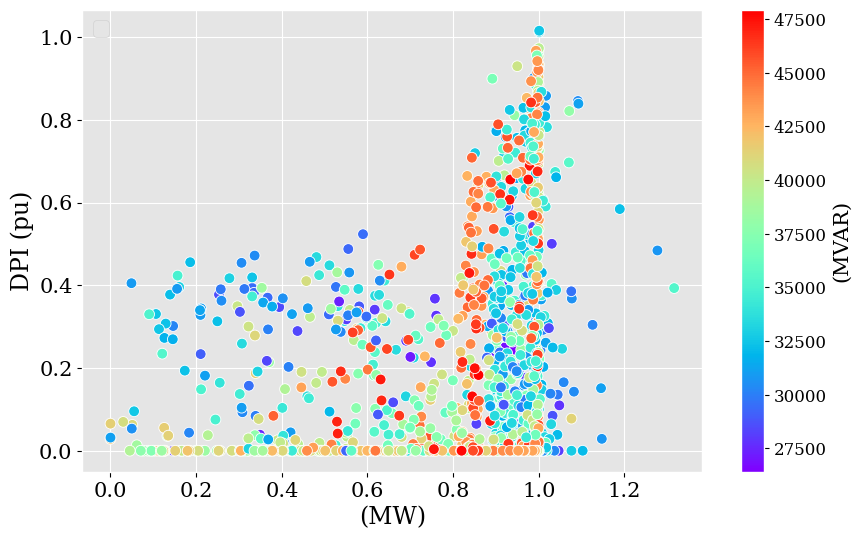

Indice de Correlación: 0.30606005292845895


In [40]:
scatterplot_1(dfanalise, 'DPI_inf_SE-CW_UHE','DPI_inf_SE-CW_500.0','DPI_inf_SE-CW_230.0')
scatterplot_1(dfanalise, 'DPI_inf_SE-CW_SIN','DPI_inf_SE-CW_500.0','DPI_inf_SE-CW_230.0')
scatterplot_1(dfanalise, 'DPI_sup_SE-CW_UHE','DPI_sup_SE-CW_230.0','PL_MW_SE-CW')

In [41]:
def scatterplot_2(df, v1, v2,v3 = None, xlimites = None, ylimites = None, namedir = None):

    cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
    plt.figure(figsize=(10, 6))
    if v3 == None:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, s=60, legend=None)
    else:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, palette=cmap, hue=v3, s=60, legend=None)
        norm = mcolors.Normalize(vmin=df[v3].min(), vmax=df[v3].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', label='(MW)',)
        # Set color bar tick labels to black
        cbar.ax.yaxis.set_tick_params(color='black',labelsize=12)
        plt.setp(cbar.ax.get_yticklabels(), color='black')
        # Set the color and size of the color bar legend label
        cbar.set_label('(MVAR)', fontsize=15, color='black')

    nometitulo = ''
    plt.title(nometitulo, fontsize = 15)
    plt.xlabel('(MW)', fontsize = 17, color ='black')
    plt.legend(fontsize = 15, loc='upper left')
    plt.ylabel('DPI (pu)', fontsize = 17, color ='black')
    # plt.axhline(1, color='red', linestyle='--', alpha=0.9)
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    plt.tick_params(axis='x', colors='black',labelsize=15, rotation = 0)  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    if xlimites != None:
        plt.xlim(xlimites)
    if ylimites != None:
        plt.ylim(ylimites)
        
    plt.show()

In [42]:
def indice_reativo (df, tg, pinf: bool):
    if pinf:
        pass
    else:
        n=2
        df['Ind_Qmin'] = df['ReservaIND'] ** (2 * n)
        df['Ind_Qmax'] = df['ReservaCAP'] ** (2 * n)
        df1 = df.groupby(['Dia', 'Hora', 'Cenario', 'REG', tg]).agg({'Ind_Qmin': 'sum', 'Ind_Qmax': 'sum'})
        df1['Qmin_norm'] = df1['Ind_Qmin']**(1 / (2 * n))
        df1['Qmax_norm'] = df1['Ind_Qmax']**(1 / (2 * n))
        
    return df1

In [43]:
def IndiceLinhas(df, n):

    df['MW_Flow'] = np.where(df['MW:From-To'] >= 0, df['MW:From-To'], df['MW:To-From'])
    df['PI_mva'] = (df['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt = df.groupby(
        ['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    # df_r_nt['PFI'] = df_r_nt['MW_Flow'] / df_r_nt['MVA']
    df_r_nt['Mva_index'] = df_r_nt['PI_mva'] ** (1 / (2 * n))

In [45]:
col1 = ['Dia','Hora','REG', 'Cenario','MODV_PU','IndiceInf', 'IndiceSup','Gen_Type','VBASEKV']
col2 = ['PL_MW', 'QL_MVAR','ReservaIND','ReservaCAP']
df1 = df_complete[col1].merge(Df_data_completo_reg[col2], on=['Dia','Hora','REG', 'Cenario'], how='left')
df11 = df1[(df1['REG']=='SE-CW') & (df1['VBASEKV']==500)]

In [46]:
col1 = ['Dia','Hora','REG', 'Cenario','MODV_PU','IndiceInf', 'IndiceSup','Gen_Type','ReservaIND','ReservaCAP', 'PG_MW', 'QG_MVAR']
col2 = ['PL_MW', 'QL_MVAR']
df2 = df_filt_ger[col1].merge(Df_data_completo_reg[col2], on=['Dia','Hora','REG', 'Cenario'], how='left')
df22= df2[(df2['REG']=='SE-CW') & (df2['Gen_Type']=='UHE')]

C:\Users\david\AppData\Local\Temp\ipykernel_25472\417925670.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


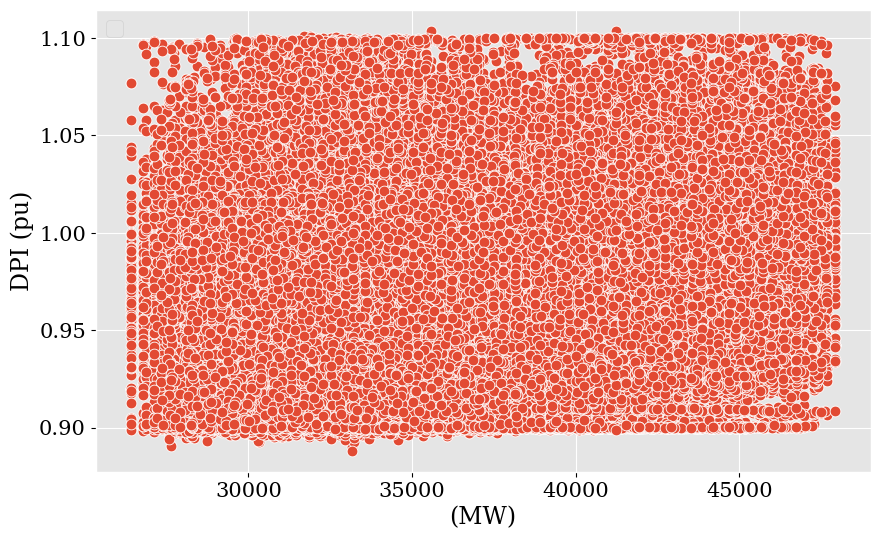

C:\Users\david\AppData\Local\Temp\ipykernel_25472\417925670.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


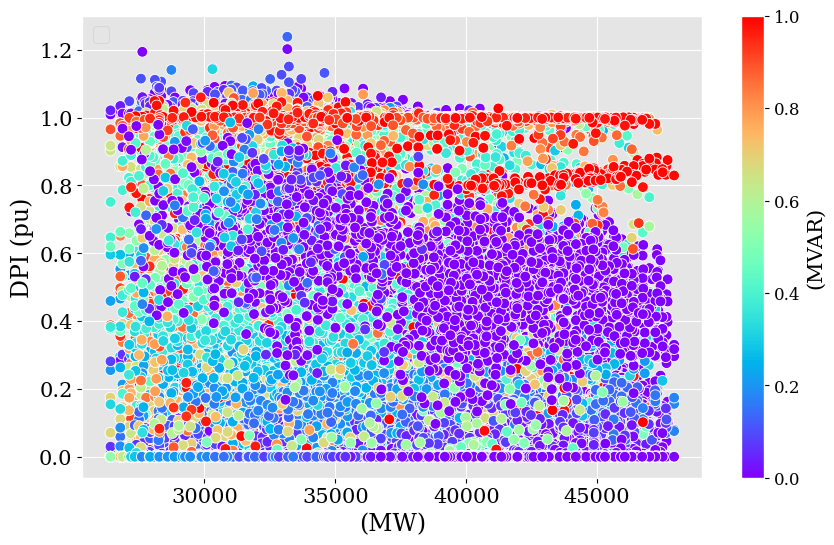

C:\Users\david\AppData\Local\Temp\ipykernel_25472\417925670.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


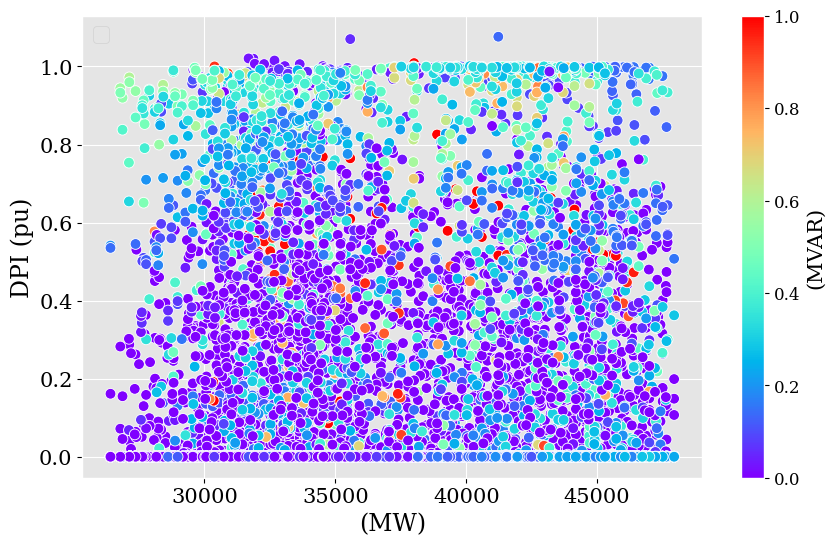

In [47]:
scatterplot_2(df22[df22['QG_MVAR']!=0], 'PL_MW', 'MODV_PU')
scatterplot_2(df22[df22['QG_MVAR']!=0], 'PL_MW', 'IndiceInf', 'ReservaIND')
scatterplot_2(df22[df22['QG_MVAR']!=0], 'PL_MW', 'IndiceSup', 'ReservaCAP')

C:\Users\david\AppData\Local\Temp\ipykernel_25472\417925670.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


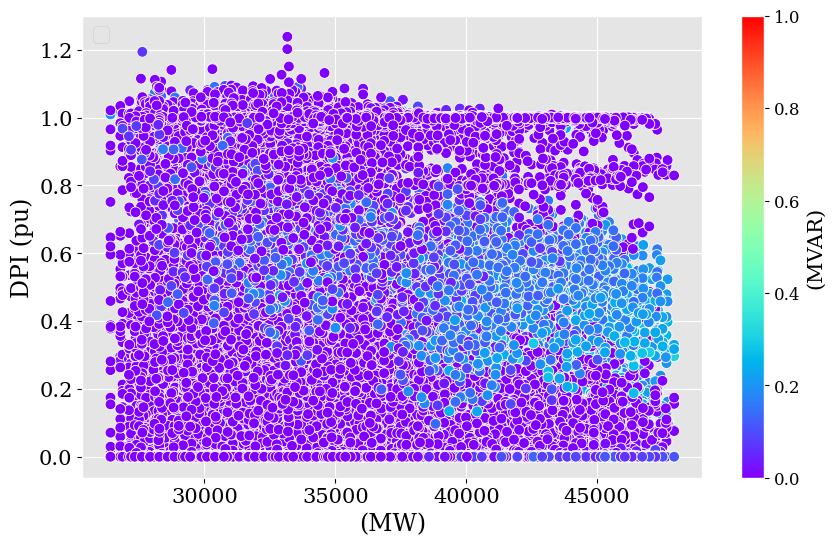

In [48]:
scatterplot_2(df22[df22['QG_MVAR']!=0], 'PL_MW', 'IndiceInf', 'ReservaCAP')

In [49]:
col1 = ['Dia','Hora','REG', 'Cenario','MODV_PU','IndiceInf', 'IndiceSup','VBASEKV']
col2 = ['PL_MW', 'QL_MVAR','ReservaIND','ReservaCAP']
df3 = df_filt_nt[col1].merge(Df_data_completo_reg[col2], on=['Dia','Hora','REG', 'Cenario'], how='left')
df33 = df3[(df3['REG']=='SE-CW') & (df3['VBASEKV']==500)]

C:\Users\david\AppData\Local\Temp\ipykernel_25472\417925670.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


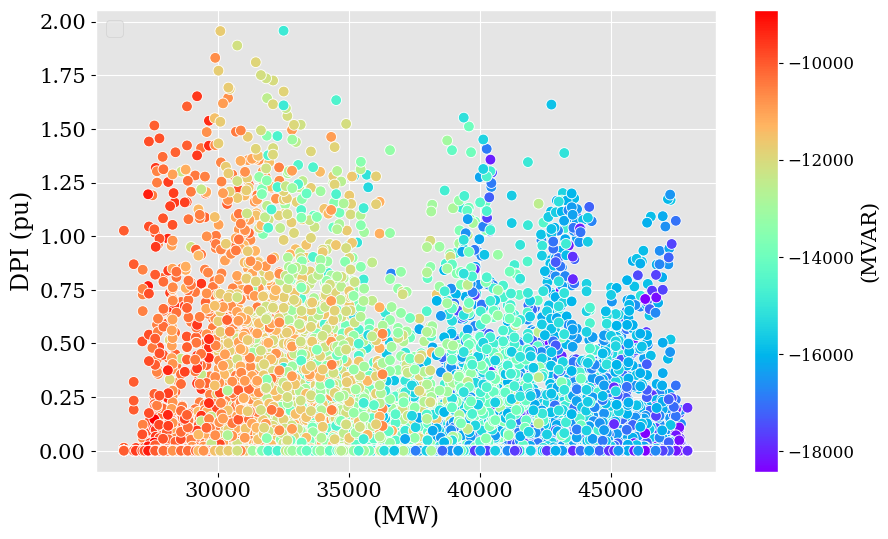

In [50]:
scatterplot_2(df33, 'PL_MW', 'IndiceInf', 'ReservaIND')

C:\Users\david\AppData\Local\Temp\ipykernel_25472\417925670.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


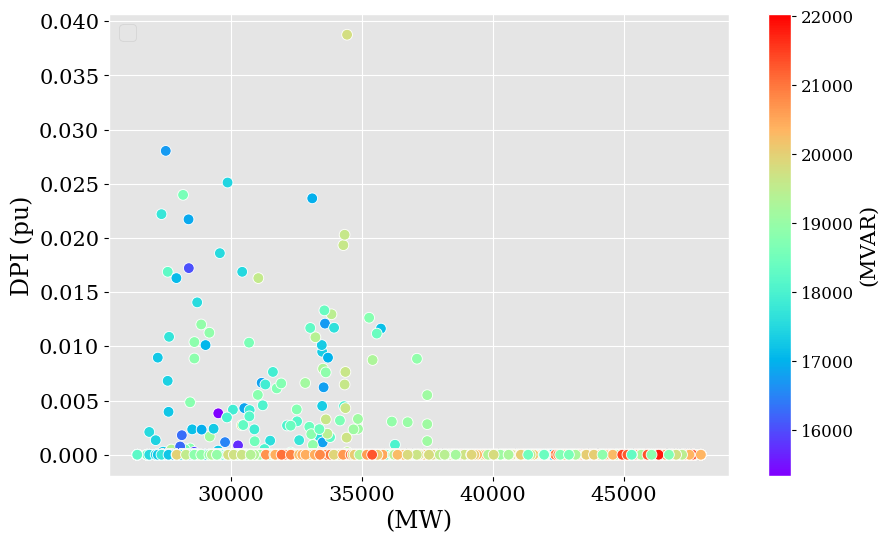

In [51]:
scatterplot_2(df33, 'PL_MW', 'IndiceSup', 'ReservaCAP')

In [52]:
# def scatterplot_0(ax, df, v1, v2, v3=None, xlimites=None, ylimites=None, namedir=None):
#     if v3 is None:
#         scatter = sns.scatterplot(ax=ax, data=df, x=v1, y=v2, s=60, legend=None)
#     else:
#         scatter = sns.scatterplot(ax=ax, data=df, x=v1, y=v2, palette='rainbow', hue=v3, s=60, legend=None)
#         norm = mcolors.Normalize(vmin=df[v3].min(), vmax=df[v3].max())
#         sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
#         sm.set_array([])
#         cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label=v3)

#     ax.grid(True, which="both", linestyle='--', linewidth=0.5)
#     nometitulo = f'Scatter plot of {v2} vs {v1}'.replace(':',' ')
#     ax.set_title(nometitulo, fontsize=15)
#     ax.set_xlabel(v1, fontsize=11)
#     ax.set_ylabel(v2, fontsize=11)
#     if xlimites is not None:
#         ax.set_xlim(xlimites)
#     if ylimites is not None:
#         ax.set_ylim(ylimites)

#     correlation = df[v1].corr(df[v2])
#     print(f"Indice de Correlación for {v1} vs {v2}: {correlation}")

# indicies = ['key_AC-RO','OV DPI_PQ_AC-RO', 'UV DPI_PQ_AC-RO', 'OV DPI_PV_AC-RO',
#        'UV DPI_PV_AC-RO', 'OV DPI_PQ_Northeast', 'UV DPI_PQ_Northeast',
#        'OV DPI_PV_Northeast', 'UV DPI_PV_Northeast', 'OV DPI_PQ_North',
#        'UV DPI_PQ_North', 'OV DPI_PV_North', 'UV DPI_PV_North',
#        'OV DPI_PQ_SE-CW', 'UV DPI_PQ_SE-CW', 'OV DPI_PV_SE-CW',
#        'UV DPI_PV_SE-CW', 'OV DPI_PQ_South', 'UV DPI_PQ_South',
#        'OV DPI_PV_South', 'UV DPI_PV_South']

# filtered_df = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 1).any(axis=1)].loc[:,:,:,'V2A2F2 2026']
# print(filtered_df.shape)
# Vinst = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/critical_code4_10.csv').rename(columns={'OP':'key_AC-RO'})
# display(Vinst[Vinst['key_AC-RO'].isin(np.sort(filtered_df.index.get_level_values('key')))])

# dfinstensao = dfanalise.loc[:,:,'V2A2F2 2026'].merge(Vinst, on='key_AC-RO', how='inner')[indicies + ['count']]
# listindicepair = [('OV DPI_PQ_AC-RO', 'OV DPI_PV_AC-RO'), ('UV DPI_PQ_AC-RO', 'UV DPI_PV_AC-RO'), ('OV DPI_PQ_Northeast','OV DPI_PV_Northeast'),
#        ('UV DPI_PQ_Northeast', 'UV DPI_PV_Northeast'), ('OV DPI_PQ_North', 'OV DPI_PV_North'), ('UV DPI_PQ_North', 'UV DPI_PV_North'),
#        ('OV DPI_PQ_SE-CW', 'OV DPI_PV_SE-CW'), ('UV DPI_PQ_SE-CW','UV DPI_PV_SE-CW'), ('OV DPI_PQ_South','OV DPI_PV_South'),
#        ( 'UV DPI_PQ_South', 'UV DPI_PV_South')]

# # Define number of rows and columns for the subplot grid
# num_rows = len(listindicepair) // 2
# num_cols = 2

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
# axes = axes.flatten()

# for idx, (ind1, ind2) in enumerate(listindicepair):
#     scatterplot_0(axes[idx], dfinstensao, ind2,ind1, 'count')

# plt.tight_layout()
# plt.show()


In [53]:
# Vinst = pd.read_csv('C:/Users/david/OneDrive/Documents/FERV_documentos/critical_code4_10.csv').rename(columns={'OP':'key_AC-RO'})
# dpidecompints = dfanalise.loc[:,:,'V2A2F2 2026'].merge(Vinst, on='key_AC-RO', how='inner').sort_values('count', ascending = False).iloc[:,5:-2]
# max_columns = dpidecompints.iloc[:, :].idxmax(axis=1)
# # Getting the maximum values themselves
# max_values = dpidecompints.iloc[:, :].max(axis=1)
# print("Columns with maximum values:")
# print(max_columns)
# print("Maximum values:")
# print(max_values)

In [54]:
# # Getting the column names with the maximum values
# max_columns = dfinstensao.iloc[:, 1:-1].idxmax(axis=1)
# # Getting the maximum values themselves
# max_values = dfinstensao.iloc[:, 1:-1].max(axis=1)
# print("Columns with maximum values:")
# print(max_columns)
# print("Maximum values:")
# print(max_values)

In [55]:
# plot_potencia_perfil_2(df_mask, dfanalise.reset_index()[dfanalise.reset_index()['Cenario']=='V2A2F2 2026'], ['Fluxo_N-S'], ['PG_MW_North'],'(MW)', ylabelrigth='(MW)', markers=False)
# # plot_potencia_perfil_2(df_mask, dfanalise.reset_index()[dfanalise.reset_index()['Cenario']=='V2A2F2 2026'], ['Fluxo_N-S'], ['Fluxo_NE-SE'],'(MW)', ylabelrigth='(MW)', markers=False)
# plot_potencia_perfil_2(df_mask, dfanalise.reset_index()[dfanalise.reset_index()['Cenario']=='V2A2F2 2026'], ['Fluxo_N-S'], ['% L1_500down_SE-CW'],'(MW)', ylabelrigth='(MW)', markers=False)

In [56]:
# plot_potencia_perfil_2(df_mask, dfanalise, ['OV DPI_PV_AC-RO'], ['QG_MVAR_AC-RO'], markers=False, ylim=[0,2])
# plot_potencia_perfil_2(df_mask, dfanalise, ['OV DPI_PV_AC-RO'], ['JARAR-PCH138'], markers=False, ylim=[0,2])
# plot_potencia_perfil_2(df_mask, dfanalise, ['OV DPI_PV_North'], ['% L1 | SLUIS2-MA230 | SLUIS4-MA230'], markers=False, ylim=[0,2])

In [57]:
# DFF6 = DF_complete_PO.merge(DATA['df_indice_grop'], on=['Dia', 'Hora', 'Cenario'], how='left').reset_index()
# plot_potencia_perfil_2(df_mask, DFF6[DFF6['Cenario']==target_scenario], ['S_Antonio_MW'],'DPI_PO_final', markers=False)
# plot_potencia_perfil_2(df_mask, DFF6[DFF6['Cenario']==target_scenario], ['Tucurui_MW'],'DPI_PO_final', markers=False)
# plot_potencia_perfil_2(df_mask, DFF6[DFF6['Cenario']==target_scenario], ['B_Monte_MW'],'DPI_PO_final', markers=False)
# plot_potencia_perfil_2(df_mask, DFF6[DFF6['Cenario']==target_scenario], ['I_Solt_MW'],'DPI_PO_final', markers=False)
# plot_potencia_perfil_2(df_mask, DFF6[DFF6['Cenario']==target_scenario], ['Jirau_MW'],'DPI_PO_final', markers=False)

# plot_potencia_perfil(df_mask, DFF6, 'Jirau_MW', markers=False)
# plot_potencia_perfil(df_mask, DFF6, 'S_Antonio_MW', markers=False)
# plot_potencia_perfil(df_mask, DFF6, 'B_Monte_MW', markers=False)
# plot_potencia_perfil(df_mask, DFF6, 'Tucurui_MW', markers=False)
# plot_potencia_perfil(df_mask, DFF6, 'I_Solt_MW', markers=False)
# plot_potencia_perfil(df_mask, DFF6, 'Itaipu_50_MW', markers=False)
# plot_potencia_perfil(df_mask, DFF6, 'Itaipu_60_MW', markers=False)

In [58]:
# df_aux_sup = DATA['features_sup_pv_df'].merge(DATA['features_sup_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
# datapd_ov = DFF6.merge(df_aux_sup, on=['Dia','Hora','Cenario'], how='left').reset_index()
# df_aux_inf = DATA['features_inf_pv_df'].merge(DATA['features_inf_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
# datapd_uv = DFF6.merge(df_aux_inf, on=['Dia','Hora','Cenario'], how='left').reset_index()

# plot_potencia_perfil_2(df_mask, datapd_uv[datapd_uv['Cenario']==target_scenario], ['DPI_PO_final'], ['BUGRESPCH006'], markers=False)
# plot_potencia_perfil_2(df_mask, datapd_uv[datapd_uv['Cenario']==target_scenario], ['DPI_PO_final'], ['LECHUG-AM500'], markers=False)

## Analise Correlação e Distribução Intercambios e Linhas

In [59]:
# def scatterplot(df, v1, v2,v3 = None, xlimites = None, ylimites = None, namedir = None):

#     cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
#     plt.figure(figsize=(10, 6))
#     if v3 == None:
#         scatter = sns.scatterplot(data=df, x=v1, y=v2, s=60, legend=None)
#     else:
#         scatter = sns.scatterplot(data=df, x=v1, y=v2, palette=cmap, hue=v3, s=60, legend=None)
#         norm = mcolors.Normalize(vmin=df[v3].min(), vmax=df[v3].max())
#         sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#         sm.set_array([])
#         cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', label=v3)

#     # plt.grid(True, which="both", linestyle='--', linewidth=0.5)
#     # nometitulo = f'{namedir} Scatter plot of {v2} vs {v1}'.replace(':',' ')
#     # nometitulo = f'Scatter plot of {v2} vs {v1}'.replace(':',' ')
#     nometitulo = ''
#     plt.title(nometitulo, fontsize = 15)
#     plt.xlabel(v1, fontsize = 17)
#     plt.ylabel(v2, fontsize = 17)
#     plt.tick_params(axis='both', labelsize=15)
#     # plt.axhline(0, color='red', linestyle='--', alpha=0.9)
#     if xlimites != None:
#         plt.xlim(xlimites)
#     if ylimites != None:
#         plt.ylim(ylimites)
        
#     # if namedir != None:
#         # nome = folderimg+'Correlações/' + namedir + nometitulo + '.svg'
#         # # plt.savefig(nome)
#         # nome = folderimg+'Correlações/' + namedir + nometitulo + '.png'
#         # # plt.savefig(nome)
#     plt.show()

#     correlation = df[v1].corr(df[v2])
#     print(f"Indice de Correlación: {correlation}")


In [60]:
# scatterplot(Df_data_completo_reg.loc[:,:,'South',:], 'PL_MW', '% L1_500down', 'PG_MW')
# scatterplot(Df_data_completo_reg.loc[:,:,'South',:], 'PL_MW', '% L1_500down', 'Mvar:Losses_500down')

# scatterplot(Df_data_completo_reg.loc[:,:,'AC-RO',:], 'PL_MW', '% L1_500down', 'PG_MW', ylimites=[-10,200])
# scatterplot(Df_data_completo_reg.loc[:,:,'AC-RO',:], 'PL_MW', '% L1_500down', 'Mvar:Losses_500down', ylimites=[-10,200])

In [61]:
# scatterplot(dfanalise, 'B_Monte_MW' , 'Fluxo_N-S', 'Mvar:Losses_500up_SE-CW')
# scatterplot(Df_data_completo_reg.loc[:,:,'AC-RO',:], 'PL_MW', 'Mvar:Losses_500down', 'PG_MW')
# scatterplot(Df_data_completo_reg.loc[:,:,'South',:], 'PL_MW', '% L1_500down', 'Mvar:Losses_500down')

In [62]:
# df_linhas_500up = DATA['df_linhas'][DATA['df_linhas']['VBASEKV'].isin([500, 525, 765])]
# df_linhas_500down = DATA['df_linhas'][DATA['df_linhas']['VBASEKV'].isin([230, 345, 440])]
# df_linhas_500up_grouped = df_linhas_500up.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up'})
# df_linhas_500down_grouped = df_linhas_500down.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down'})
# df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)
# dfff_lines = DATA['df_linhas'].drop_duplicates(subset=['From#', 'To#']).groupby(by=['Dia', 'Hora', 'Cenario','REG','VBASEKV']).count()
# dfff_lines.loc[1,'00-00','V2A2F2 2026',dfff_lines.index.get_level_values('VBASEKV').isin([230,345,440,500,525])]

# Analise Intercambios e Linhas

In [63]:
df_linhas_500up = DATA['df_linhas'][DATA['df_linhas']['VBASEKV'].isin([500, 525, 765])]
df_linhas_500down = DATA['df_linhas'][DATA['df_linhas']['VBASEKV'].isin([230, 345, 440])]
df_linhas_500up_grouped = df_linhas_500up.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'MW_Flow': 'sum','% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'MW_Flow': 'MW_Flow_over500','% L1': '% L1_over500', 'Mvar:Losses': 'Mvar:Losses_over500'})
df_linhas_500down_grouped = df_linhas_500down.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'MW_Flow': 'sum','% L1': 'mean', 'Mvar:Losses': 'sum'}).rename(columns={'MW_Flow': 'MW_Flow_under500','% L1': '% L1_under500', 'Mvar:Losses': 'Mvar:Losses_under500'})
df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)
df_linhas_grouped_REG = df_linhas_grouped_REG.rename(index=regionmap, level='REG')

In [64]:
def boxplot_linhas(df, clase, yvalue, titulo, xlbl, ylbl, ylim = None):
    df = df.reset_index()
    plt.figure(figsize=(12, 6))

    ax = sns.boxplot(data=df, x=clase, y=yvalue, hue="Cenario", width=0.8, linewidth=1.5, palette="mako",flierprops={'markerfacecolor': 'gray', 'marker': 'o'})
    # Customize axes spines
    border_color = 'black'
    linewidth = 1.2
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)

    # Customize the boxplot elements
    for cap in ax.artists:
        cap.set_edgecolor(border_color)
        cap.set_facecolor('white')

    for median in ax.lines:
        median.set_color('darkblue')
        median.set_linewidth(1.5)

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=16, color='black')
    plt.ylabel(ylbl, fontsize=16, color='black')
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    plt.legend(title='Scenarios', loc='best', fontsize=13)
    #labels
    plt.tick_params(axis='x', colors='black')  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    if ylim !=  None:
        plt.ylim(ylim)
    plt.show()
    
if Analise_Linhas:
    filtrolinh = set(df_linhas_500down[(df_linhas_500down['REG']=='AC-RO') & (df_linhas_500down['% L1']>50)][['Dia','Hora']].apply(tuple, axis=1).values)
    filter_outliers = Df_data_completo_reg.index.to_frame()[['Dia', 'Hora']].apply(tuple, axis=1).isin(filtrolinh)
    Df_data_completo_reg_ = Df_data_completo_reg[~filter_outliers].loc[:,:,:,['V1A1F2 Scenario 2026','V1A1F5 Scenario 2026']]

    boxplot_linhas(Df_data_completo_reg_, 'REG', '% L1_500up' , 'Carregamento Médio das linhas com nivel de tensão >= 500kV', 'Region', 'Line Loading (%)', ylim = None)
    boxplot_linhas(Df_data_completo_reg_, 'REG', 'Mvar:Losses_500up' , 'Soma Perdas Reativas das linhas com nivel de tensão >= 500kV', 'Region', 'Losses (MVAR)', ylim = None)
    boxplot_linhas(Df_data_completo_reg_, 'REG', '% L1_500down' , 'Carregamento Médio das linhas com nivel de tensão < 500kV', 'Region', 'Line Loading (%)', ylim = None)
    boxplot_linhas(Df_data_completo_reg_, 'REG', 'Mvar:Losses_500down' , 'Soma Perdas Reativas das linhas com nivel de tensão < 500kV', 'Region', 'Losses (MVAR)', ylim = None)

KeyError: 'V1A1F5 Scenario 2026'

In [ ]:
def scatterplot(df, v1, v2, v3=None, xlimites=None, ylimites=None, namedir=None):
    cmap = plt.cm.get_cmap("rainbow_r")  # '_r' suffix to reverse the colormap
    plt.figure(figsize=(10, 6))
    
    if v3 is None:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, s=60, legend=None)
    else:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, palette=cmap, hue=v3, s=60, legend=None)
        norm = mcolors.Normalize(vmin=df[v3].min(), vmax=df[v3].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', label='(MVAR)',)
        # Set color bar tick labels to black
        cbar.ax.yaxis.set_tick_params(color='black',labelsize=12)
        plt.setp(cbar.ax.get_yticklabels(), color='black')
        # Set the color and size of the color bar legend label
        cbar.set_label('(MVAR)', fontsize=15, color='black')

    nometitulo = ''
    plt.title(nometitulo, fontsize=15)
    plt.xlabel('(MW)', fontsize=16, color='black')
    plt.ylabel('DPI (p.u)', fontsize=16, color='black')
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')  # Set the color for the tick labels
    plt.tick_params(axis='x', colors='black')  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks

    if xlimites is not None:
        plt.xlim(xlimites)
    if ylimites is not None:
        plt.ylim(ylimites)

    plt.show()

    correlation = df[v1].corr(df[v2])
    print(f"Indice de Correlación: {correlation}")

C:\Users\david\AppData\Local\Temp\ipykernel_17744\1302502308.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow_r")  # '_r' suffix to reverse the colormap


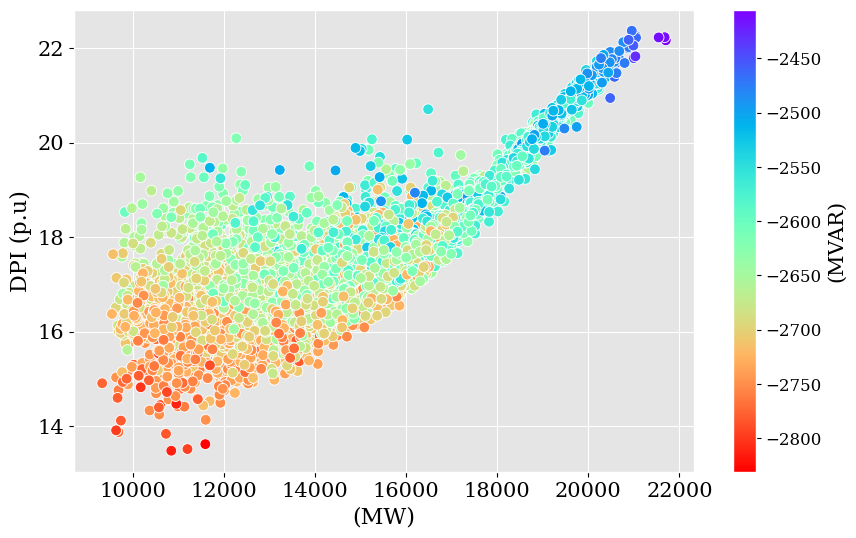

Indice de Correlación: 0.81404080668254


C:\Users\david\AppData\Local\Temp\ipykernel_17744\1302502308.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow_r")  # '_r' suffix to reverse the colormap


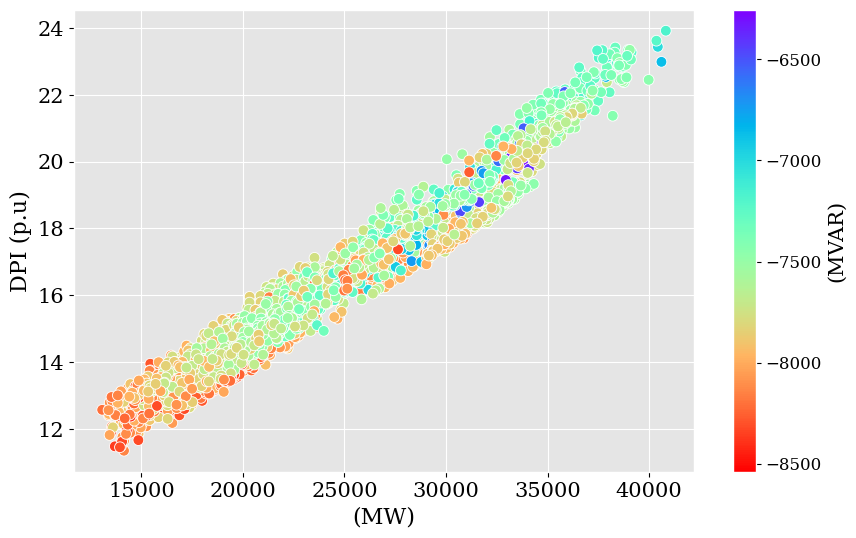

Indice de Correlación: 0.9806760838978403


In [ ]:
reg = 'South'
# scatterplot(Df_data_completo_reg.loc[:,:,'SE-CW',:], 'PL_MW', '% L1_500down', 'PG_MW', ylimites=[-10,200])
scatterplot(df_linhas_grouped_REG.loc[:,:,reg,:],'MW_Flow_under500', '% L1_under500', 'Mvar:Losses_under500')
scatterplot(df_linhas_grouped_REG.loc[:,:,reg,:],'MW_Flow_over500', '% L1_over500', 'Mvar:Losses_over500')

In [ ]:
# boxplot_linhas(df_linhas_grouped_REG.loc[:,:,:,['V2A2F2 2026','V2A2F5 2026']], 'REG', 'MW_Flow_under500' , 'Soma do Fluxo das linhas com nivel de tensão < 500kV', 'Region', '(MW)', ylim = None)

In [ ]:
df_1 = DATA['df_Inter_AC_DC'].reset_index().melt(id_vars=['key','Dia', 'Hora', 'Cenario'], var_name='Intercambio', value_name='Value')
df_fluxos_AC = df_1[df_1['Intercambio'].isin(['Fluxo_N-S', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_SUL-SECO'])]
df_fluxos_DC = df_1[df_1['Intercambio'].isin(['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE'])]
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


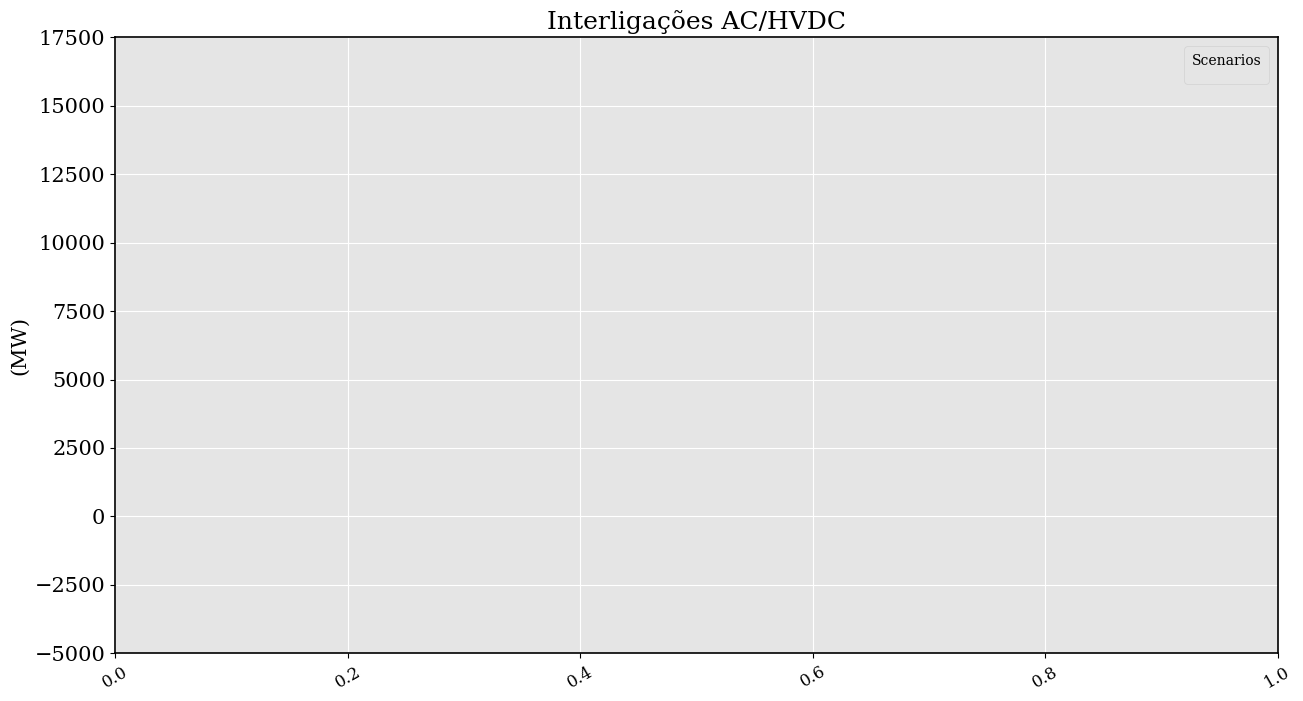

In [ ]:
boxplot_(df_1[df_1['Cenario'].isin(['V2A2F2 2026','V2A2F5 2026'])],'Value', clase = "Intercambio", hue='Cenario', titulo = 'Interligações AC/HVDC', xlbl = '',ylbl ='(MW)')

In [ ]:
# def plot_potencia_perfil(df_resultado, df_data, column, ylim = None, markers=True,):

#     df = df_resultado.merge(df_data,on=['Dia','Hora', 'Cenario'], how='left')
#     plt.figure(figsize=(20, 7))
#     sns.lineplot(data=df, x='Dia_Hora', y=column, hue='Cenario', markers=markers, lw = 2)
#     plt.xlabel('(Dia, Hora)', fontsize = 15)
#     plt.ylabel('(MW)', fontsize = 15)
#     if column == 'DemandaLiquida':
#         plt.title(f'Demanda Liquida Total do Sistema', fontsize = 15)
#     else:
#         plt.title(f'Perfil de Potencia de {column}', fontsize = 15)

#     value = int(df['Dia_Hora'].unique().shape[0] / 28)
#     selected_ticks = df[df['Cenario'] == df['Cenario'].unique()[0]].iloc[::value]['Dia_Hora']
#     plt.xticks(selected_ticks, rotation=45, fontsize=12)
#     plt.tick_params(axis='y', labelsize=12)
#     plt.legend(title='Cenarios', fontsize = 12)
#     if ylim != None:
#         plt.ylim(ylim)
#     plt.tight_layout()
#     plt.grid()
#     plt.show()

# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_FOZ-IBIUNA', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_PVEL-ARARQ', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_XINGU-SE', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_CPVBTB-PVEL', markers=False)

In [ ]:
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_N-S', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_NE-N', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_NE-SE', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_SUL-SECO', markers=False)

In [ ]:
# # fluxoONS = pd.read_csv("C:/Users/David/OneDrive/Documents/FERV_documentos/DATA NORUS/fluxo_intercambio_NORUS_2022/fluxo_intercambio/fluxo_intercambio_FNS.csv", sep=';')
# fluxoONS = pd.read_csv("C:/Users/David/OneDrive/Documents/FERV_documentos/DATA NORUS/fluxo_intercambio_NORUS_2026_V1A1F2_FNS_lim/fluxo_intercambio_FNS.csv", sep=';')
# # fluxoONS = pd.read_csv('C:/Users/David/OneDrive/Documents/FERV_documentos/DATA NORUS/fluxo_intercambio_NORUS_2026_V1A1F2_FNS_lim_REV2/fluxo_intercambio_FNS.csv', sep=';')


# cenario = 'V2A2F2 Scenario 2026'

# fluxoONS = fluxoONS.drop(fluxoONS.columns[0], axis=1)
# fluxoONS = fluxoONS.drop(fluxoONS.columns[0], axis=1)
# fluxoONS = fluxoONS.rename(columns={'periodo': 'Dia', 'hora': 'Hora', 'MW':'Fluxo_N-S_DESSEM'})
# fluxoONS['Hora'] = fluxoONS['Hora'].str.replace(':','-')
# fluxoONS['Dia'] = fluxoONS['Dia'].str.slice(0, 2)
# fluxoONS = fluxoONS.melt(id_vars=['Dia','Hora'], value_vars='Fluxo_N-S_DESSEM', var_name='Intercambio', value_name='Value').set_index(['Dia','Hora','Intercambio'])

# df_2 = df_1[df_1['Cenario']==cenario].copy()
# df_2['Dia'] = df_2['Dia'].astype(str)
# df_2['Dia'] = df_2['Dia'].str.zfill(2)
# intercambio_previsto = df_2.set_index(['Dia', 'Hora','Intercambio']).drop(columns='Cenario')
# # intercambio_previsto = df_1.set_index(['Dia', 'Hora','Intercambio', 'Cenario'])
# # intercambio_previsto = intercambio_previsto.loc[:,:,:,'V1A1F2 Scenario 2022']

# df_compare_fluxs = pd.concat([fluxoONS,intercambio_previsto],axis = 0).reset_index()
# df_compare_fluxs['Dia'] = df_compare_fluxs['Dia'].astype(str)
# df_compare_fluxs['Dia_Hora'] = '(' + df_compare_fluxs['Dia'] + ', ' + df_compare_fluxs['Hora'] + ')'

In [ ]:
# # Assuming df_compare_fluxs is already defined
# df = df_compare_fluxs
# condition = df['Intercambio'].isin(['Fluxo_N-S','Fluxo_N-S_DESSEM'])

# # Plotting
# plt.figure(figsize=(20, 7))
# plot = sns.lineplot(data=df[condition], x='Dia_Hora', y='Value', hue='Intercambio', style=None, markers=False)
# plt.xlabel('(Dia, Hora)', fontsize=15)
# plt.ylabel('(MW)', fontsize=15)
# plt.title(f'Power Flow Profile of {cenario}', fontsize=15)
# value = int(df['Dia_Hora'].unique().shape[0] / 28)
# selected_ticks = df[df['Intercambio'] == df['Intercambio'].unique()[0]].iloc[::value]['Dia_Hora']
# plt.xticks(selected_ticks, rotation=45, fontsize=12)
# plt.tick_params(axis='y', labelsize=12)

# # Get the current handles and labels
# handles, labels = plot.get_legend_handles_labels()
# new_labels = ['Fluxo_N-S_DESSEM', 'Fluxo_N-S_HPPA']  # Update these with your desired legend names

# # Set the legend with the new labels
# plt.legend(handles, new_labels, title='Fluxos', fontsize=12)
# # Add horizontal lines
# plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
# plt.axhline(-1000, color='red', linestyle='--', alpha=0.9)

# plt.tight_layout()
# plt.grid()
# plt.show()